# Predict Churning customers

The goal of this project is to predict the customers who want to cancel a credit card program, such that actions can be taken to prevent the event from happening.

The top priority is to identify customers who are getting churned. Even if we predict non-churning customers as churned, it won’t harm our business. But predicting churning customers as non-churning will do. So recall (True positives/(True positives + False negatives) must be high.

The dataset is strongly un-balanced: only 16% of customers churned.

The notebook is organized as follow:

+ In Section 1, the dataset is explored, checking if null values are present.

+ In Section 2, feature engineering is performed as follow:
    + The categorical target feature (the Attrition_Flag) is converted to numerical.
    + Other categorical features are one-hot encoded.
    + The dataset is divided into train and test, using stratified sampling.
    + The outliers in the training dataset are identified.
    + A data preprocessing pipeline is built, removing the outliers identified in the previous step and standardizing each feature.
    + Highly correlated features are removed, identifing highly correleted feature pairs
    + Highly multicollinear features are removed, estimating the variance inflation factor

+ In Section 3, XGBoost is used as a model for predicting churned/not churned customers. Model hyperparameters are searched as follow:
    + An objective function is defined. The objective function computes the average value of the cross-validation score on the training dataset, using the negative log loss as a scoring metric
    + The maximum value of the objective function is searched using the Bayesian framework Optuna [https://optuna.org/]
    + On the test dataset, the recall value is 0.927

# Common imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

%matplotlib inline

## 1. Explore dataset

In [2]:
bankchurners = pd.read_csv("BankChurners.csv")
bankchurners.head(10)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998
5,713061558,Existing Customer,44,M,2,Graduate,Married,$40K - $60K,Blue,36,...,4010.0,1247,2763.0,1.376,1088,24,0.846,0.311,0.000055,0.99994
6,810347208,Existing Customer,51,M,4,Unknown,Married,$120K +,Gold,46,...,34516.0,2264,32252.0,1.975,1330,31,0.722,0.066,0.000123,0.99988
7,818906208,Existing Customer,32,M,0,High School,Unknown,$60K - $80K,Silver,27,...,29081.0,1396,27685.0,2.204,1538,36,0.714,0.048,0.000086,0.99991
8,710930508,Existing Customer,37,M,3,Uneducated,Single,$60K - $80K,Blue,36,...,22352.0,2517,19835.0,3.355,1350,24,1.182,0.113,0.000045,0.99996
9,719661558,Existing Customer,48,M,2,Graduate,Single,$80K - $120K,Blue,36,...,11656.0,1677,9979.0,1.524,1441,32,0.882,0.144,0.000303,0.99970


In [3]:
bankchurners.columns

Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
      dtype='object')

## Ignore the last 2 columns (as suggested by the data description section)

In [4]:
bankchurners.drop(['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], axis=1, inplace=True)

## How many NaNs values are present?

In [5]:
bankchurners.isnull().sum()

CLIENTNUM                   0
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

In [6]:
bankchurners.describe()

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,7.391776e+08,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,3.690378e+07,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,7.080821e+08,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,7.130368e+08,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,7.179264e+08,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,7.731435e+08,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,8.283431e+08,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


# 2. Feature Engineering

## CLIENTNUM will not have predictive power, it is an id

In [7]:
bankchurners.drop(['CLIENTNUM'],axis=1,inplace=True)

## Which columns are numerical and which categorical?

In [8]:
numerical_features = bankchurners._get_numeric_data().columns
numerical_features

Index(['Customer_Age', 'Dependent_count', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')

In [9]:
# Categorical Columns
categorical_features = bankchurners.select_dtypes(include='object').columns
categorical_features

Index(['Attrition_Flag', 'Gender', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category'],
      dtype='object')

## Convert the income into ordinal features, it makes sense for this categorical variable

<AxesSubplot:xlabel='Income_Category', ylabel='count'>

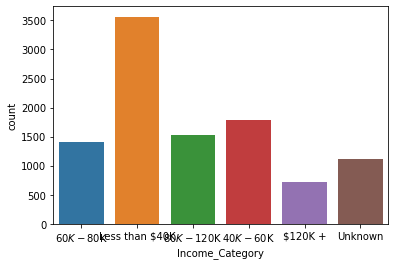

In [10]:
sns.countplot('Income_Category', data=bankchurners)

In [11]:
bankchurners['Income_Category'] = bankchurners['Income_Category'].replace({
    'Unknown':0,
    'Less than $40K':1,
    '$40K - $60K':2,
    '$60K - $80K':3,
    '$80K - $120K':4,
    '$120K +':5
})

## Convert attrition_flag to numerical

<AxesSubplot:xlabel='Attrition_Flag', ylabel='count'>

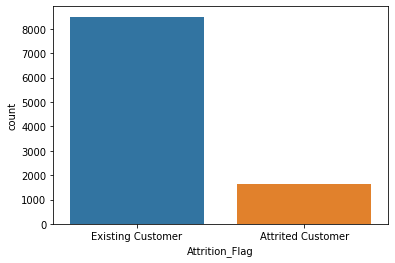

In [12]:
sns.countplot('Attrition_Flag', data=bankchurners)

In [13]:
bankchurners['Attrition_Flag'] = bankchurners['Attrition_Flag'].replace({
    'Existing Customer':0,
    'Attrited Customer':1,
})

## For the other categorical variables, use dummies (OneHot encoding)

In [14]:
categorical = bankchurners.select_dtypes(include='object').columns
categorical

Index(['Gender', 'Education_Level', 'Marital_Status', 'Card_Category'], dtype='object')

In [15]:
bankchurners = pd.get_dummies(bankchurners, columns = categorical, drop_first=True)

In [16]:
bankchurners.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Attrition_Flag                 10127 non-null  int64  
 1   Customer_Age                   10127 non-null  int64  
 2   Dependent_count                10127 non-null  int64  
 3   Income_Category                10127 non-null  int64  
 4   Months_on_book                 10127 non-null  int64  
 5   Total_Relationship_Count       10127 non-null  int64  
 6   Months_Inactive_12_mon         10127 non-null  int64  
 7   Contacts_Count_12_mon          10127 non-null  int64  
 8   Credit_Limit                   10127 non-null  float64
 9   Total_Revolving_Bal            10127 non-null  int64  
 10  Avg_Open_To_Buy                10127 non-null  float64
 11  Total_Amt_Chng_Q4_Q1           10127 non-null  float64
 12  Total_Trans_Amt                10127 non-null 

## Raname columns to remove white spaces and other charaters incompatible with patsy (used in the next section)

In [17]:
bankchurners.rename(columns={
    "Education_Level_High School": "Education_Level_High_School",
    "Education_Level_Post-Graduate": "Education_Level_Post_Graduate",
},inplace=True)
bankchurners.columns.values

array(['Attrition_Flag', 'Customer_Age', 'Dependent_count',
       'Income_Category', 'Months_on_book', 'Total_Relationship_Count',
       'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit',
       'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1',
       'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1',
       'Avg_Utilization_Ratio', 'Gender_M', 'Education_Level_Doctorate',
       'Education_Level_Graduate', 'Education_Level_High_School',
       'Education_Level_Post_Graduate', 'Education_Level_Uneducated',
       'Education_Level_Unknown', 'Marital_Status_Married',
       'Marital_Status_Single', 'Marital_Status_Unknown',
       'Card_Category_Gold', 'Card_Category_Platinum',
       'Card_Category_Silver'], dtype=object)

## Split the dataset in train and dev, before any other analysis

In [18]:
from sklearn.model_selection import train_test_split
y = bankchurners['Attrition_Flag']
X = bankchurners.drop(['Attrition_Flag'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,stratify =y)

In [19]:
train = pd.concat([X_train, y_train],axis=1)
test = pd.concat([X_test, y_test],axis=1)

## Check outliers on numerical features

In [20]:
sns.set(font_scale=1.5)
def box_plot(key):
    fig = plt.figure(figsize=(30, 20));
    sns.boxplot(x='Attrition_Flag', y=key, data=train[['Attrition_Flag', key]])

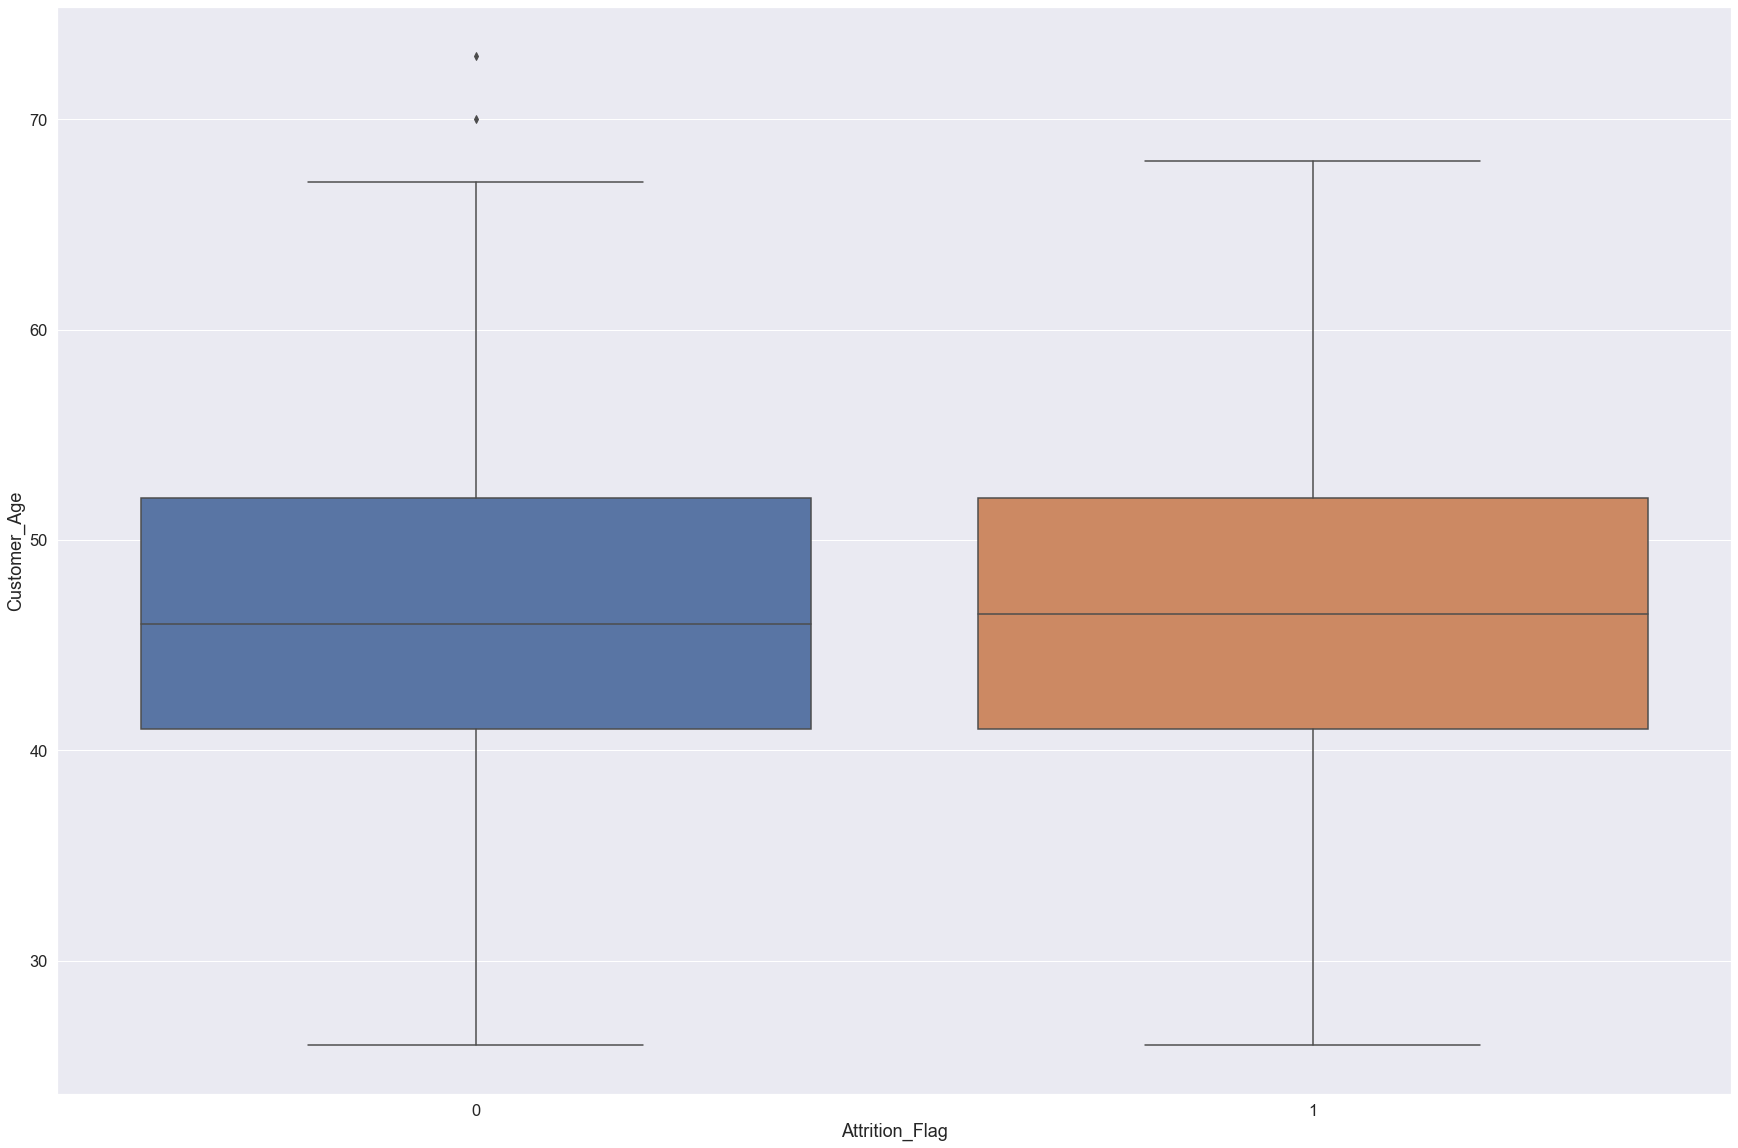

In [21]:
box_plot('Customer_Age')

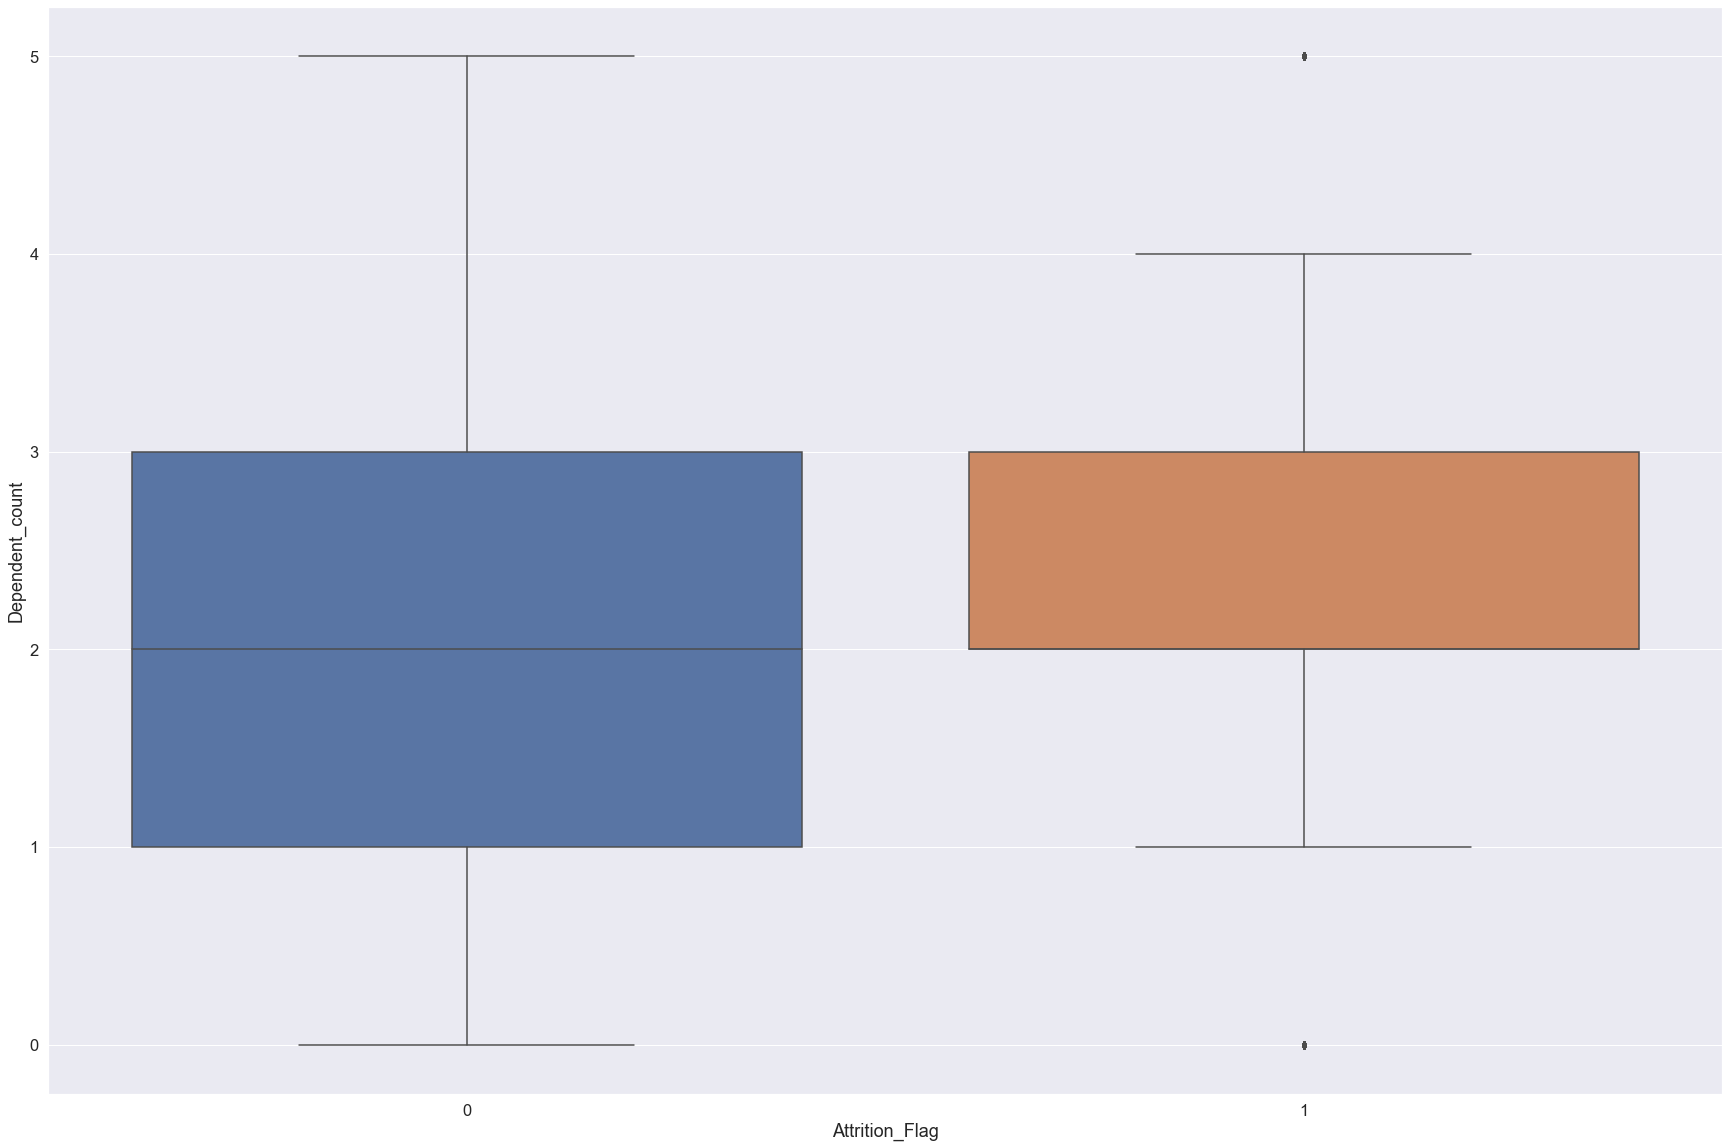

In [22]:
box_plot('Dependent_count')

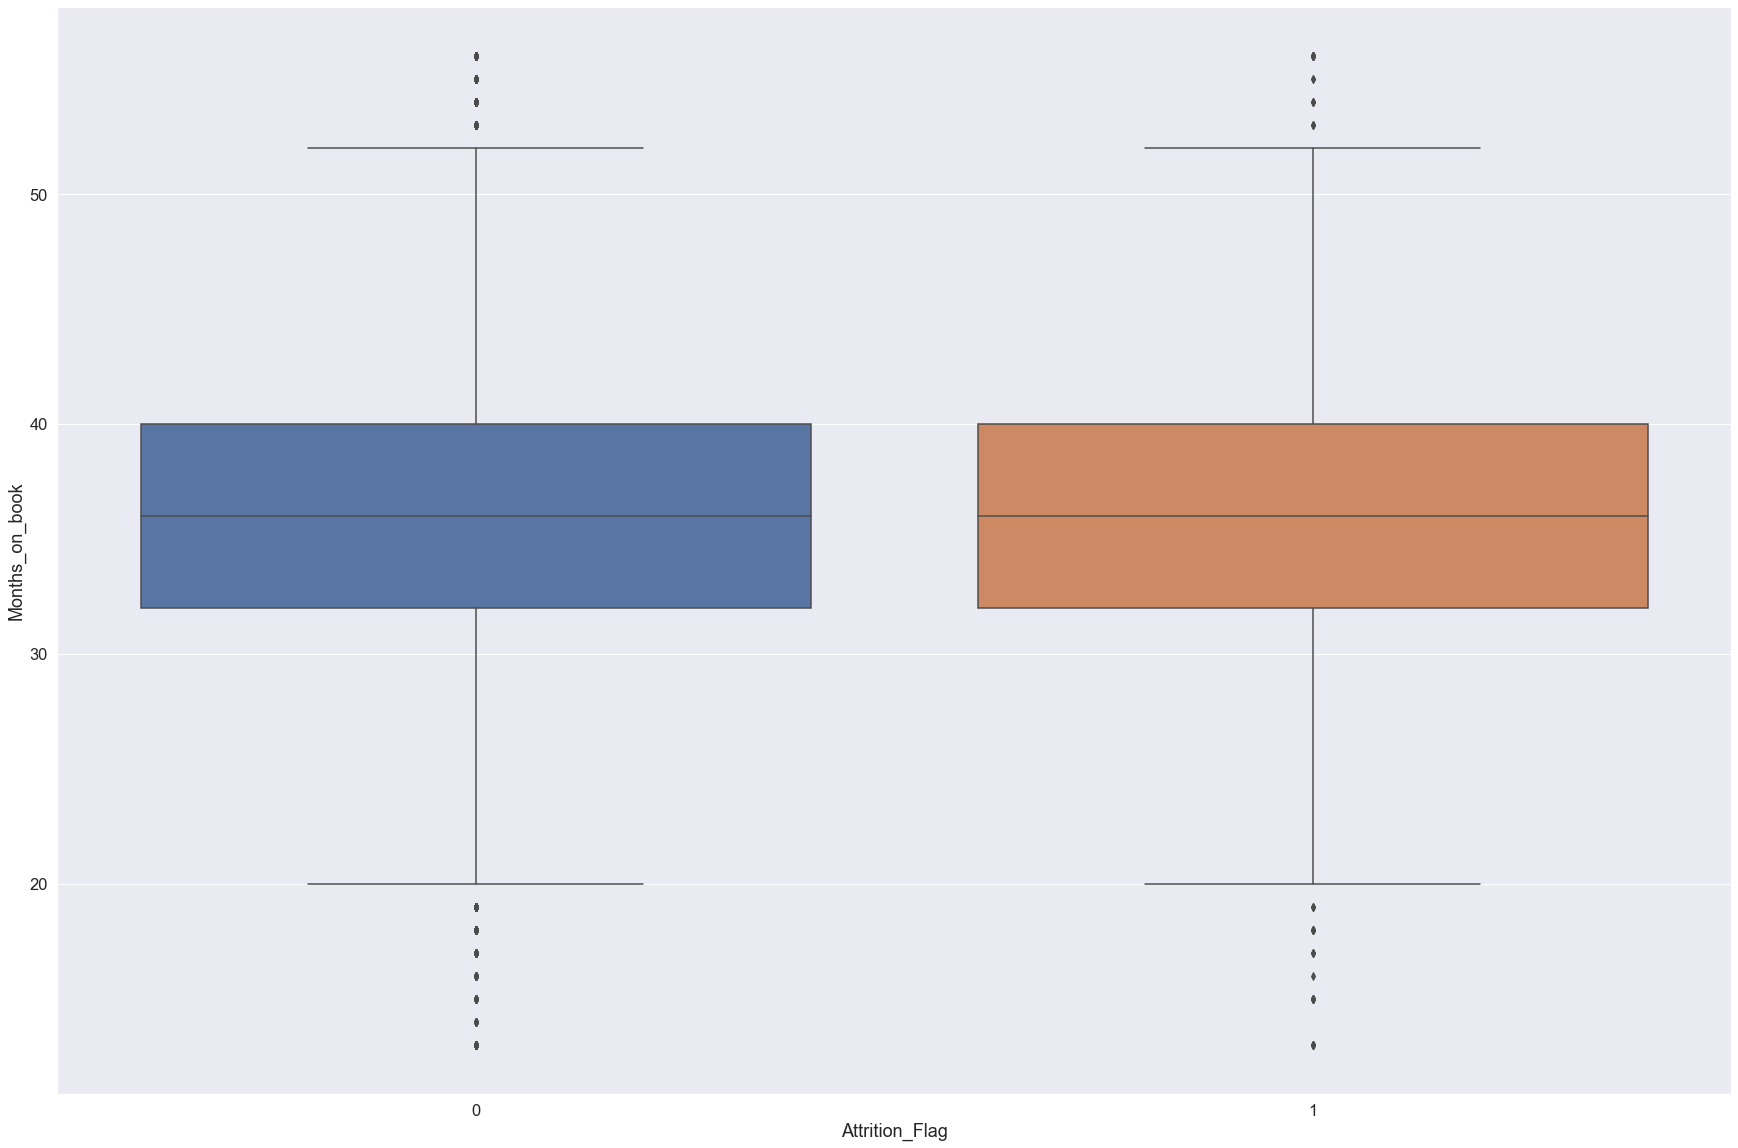

In [23]:
box_plot('Months_on_book')

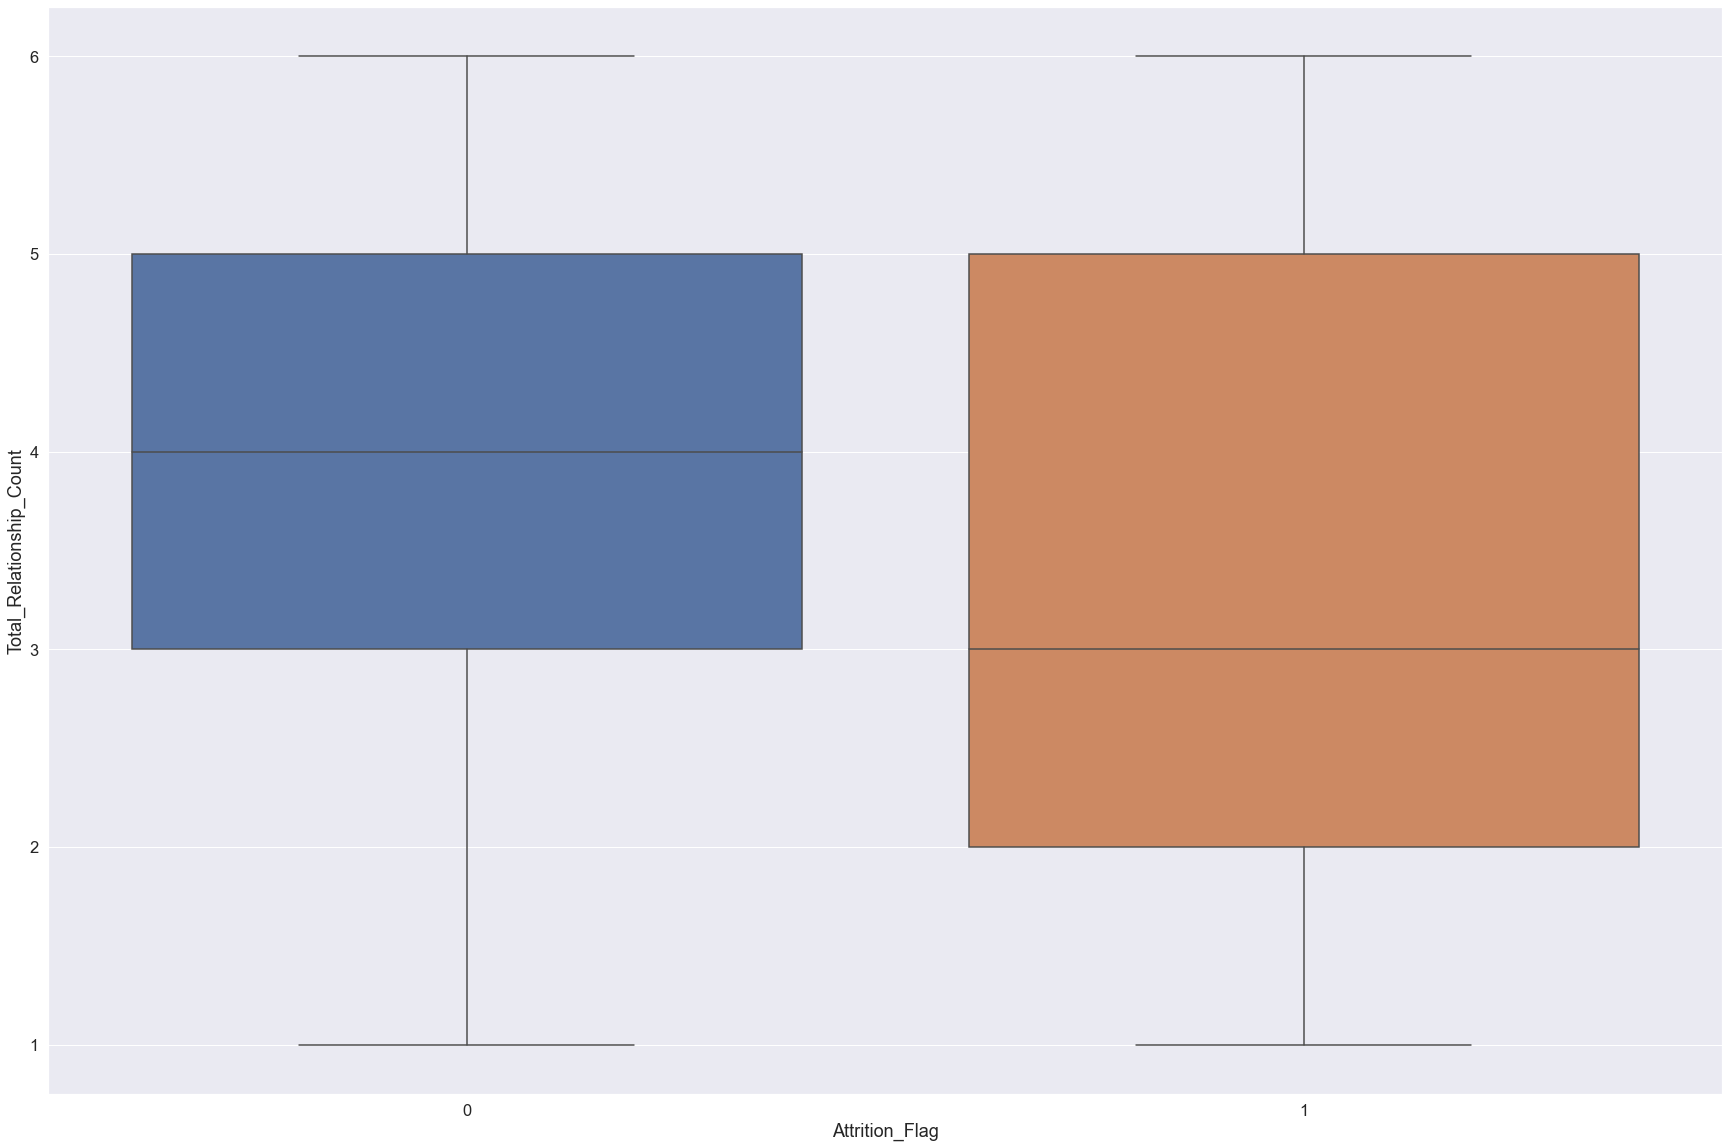

In [24]:
box_plot('Total_Relationship_Count')

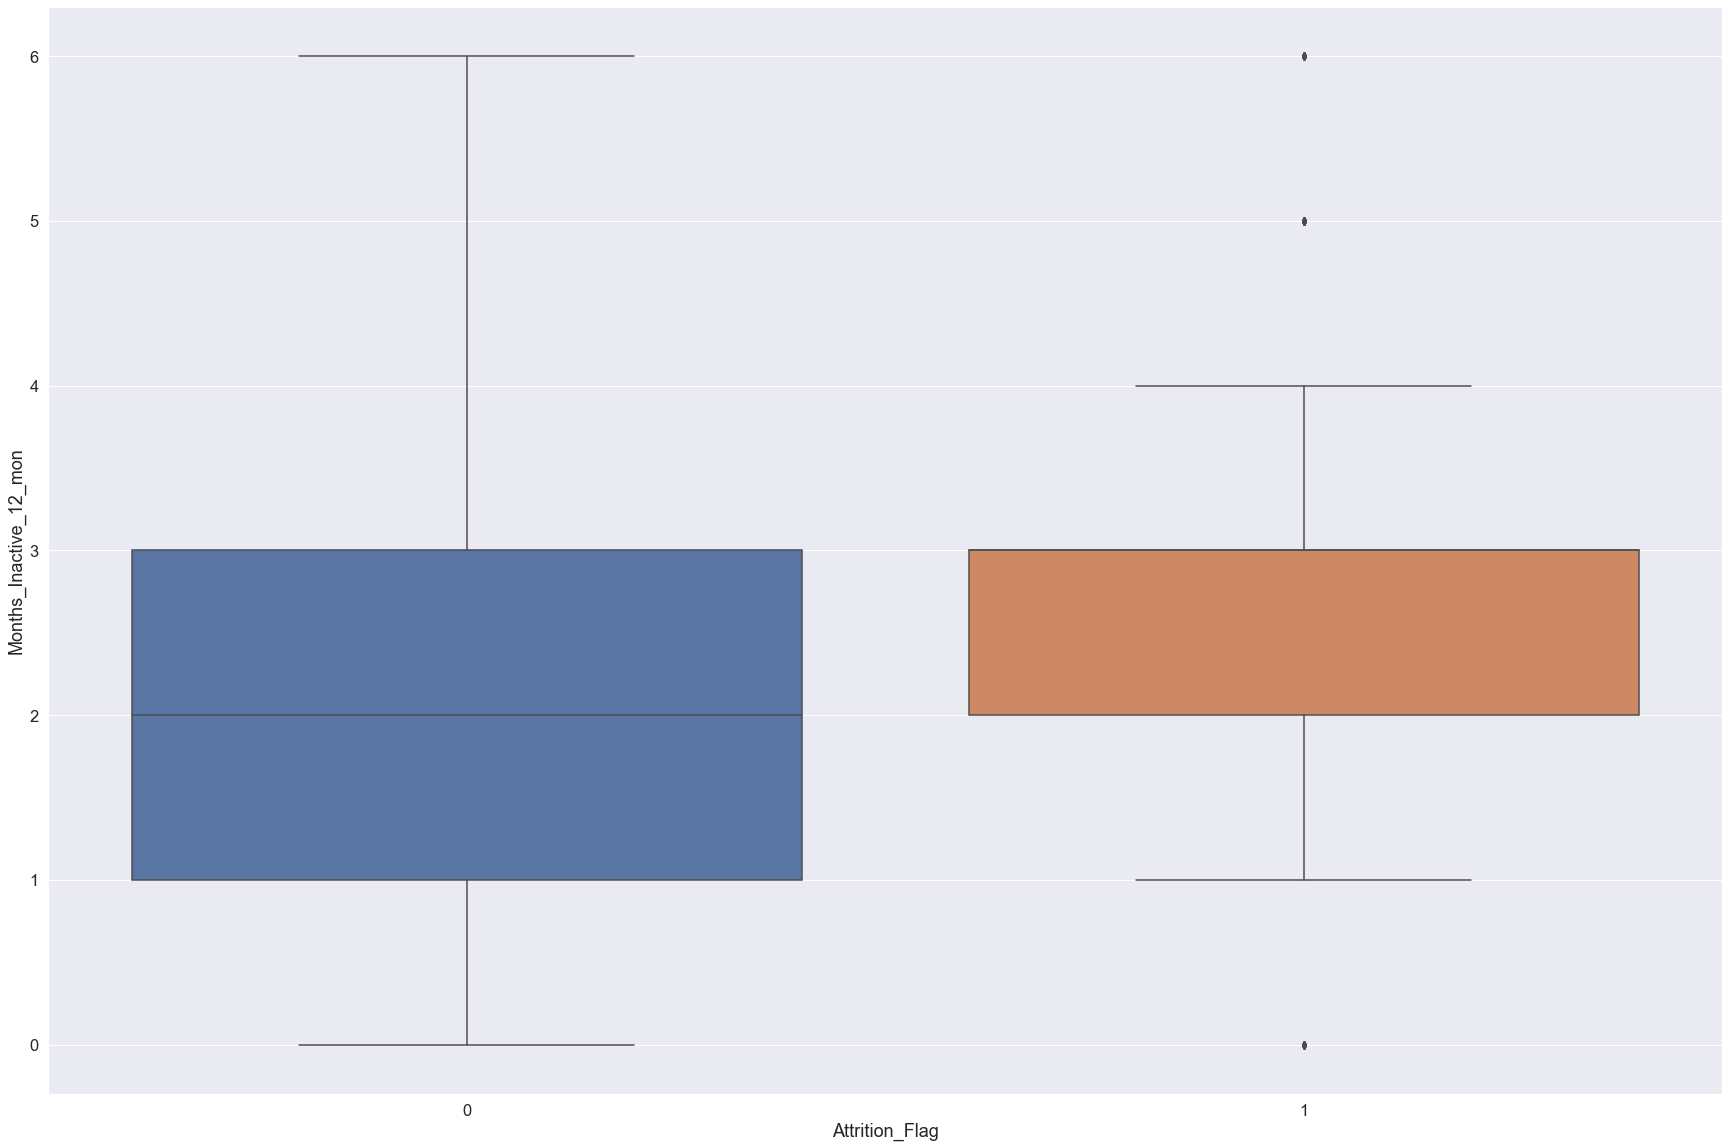

In [25]:
box_plot('Months_Inactive_12_mon')

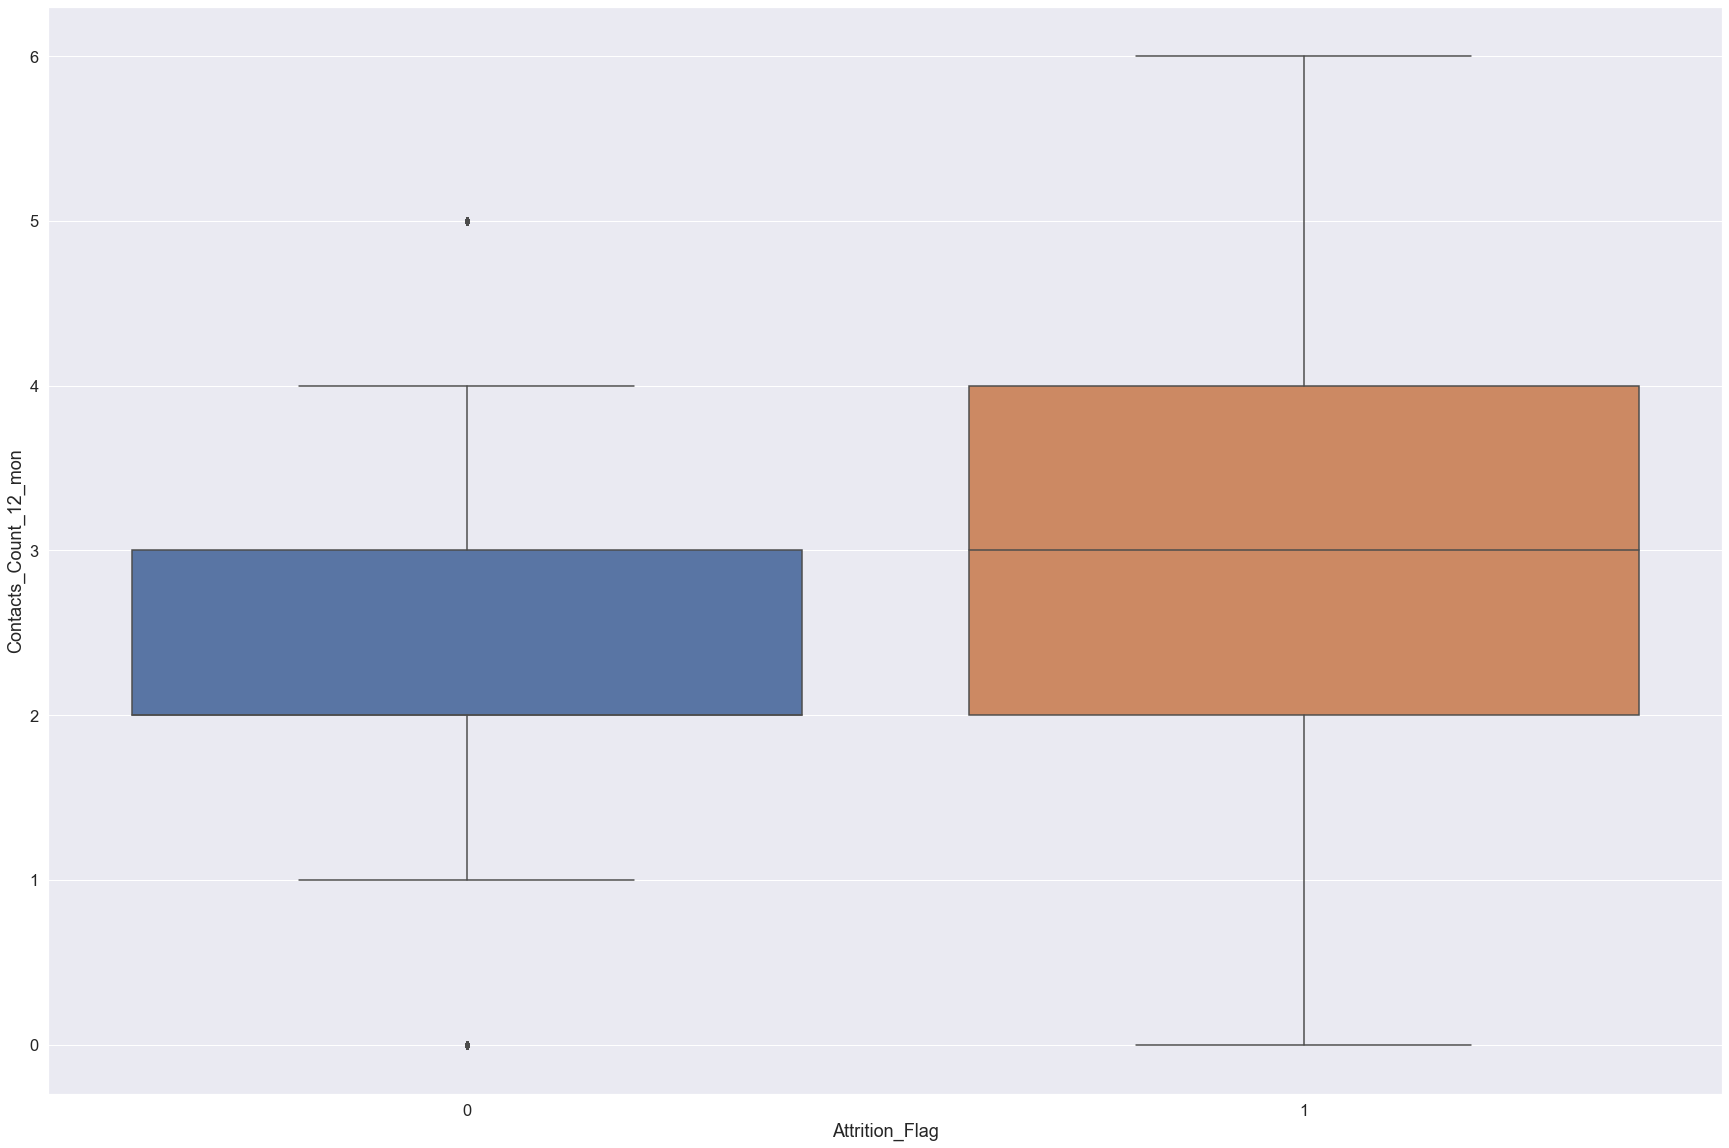

In [26]:
box_plot('Contacts_Count_12_mon')

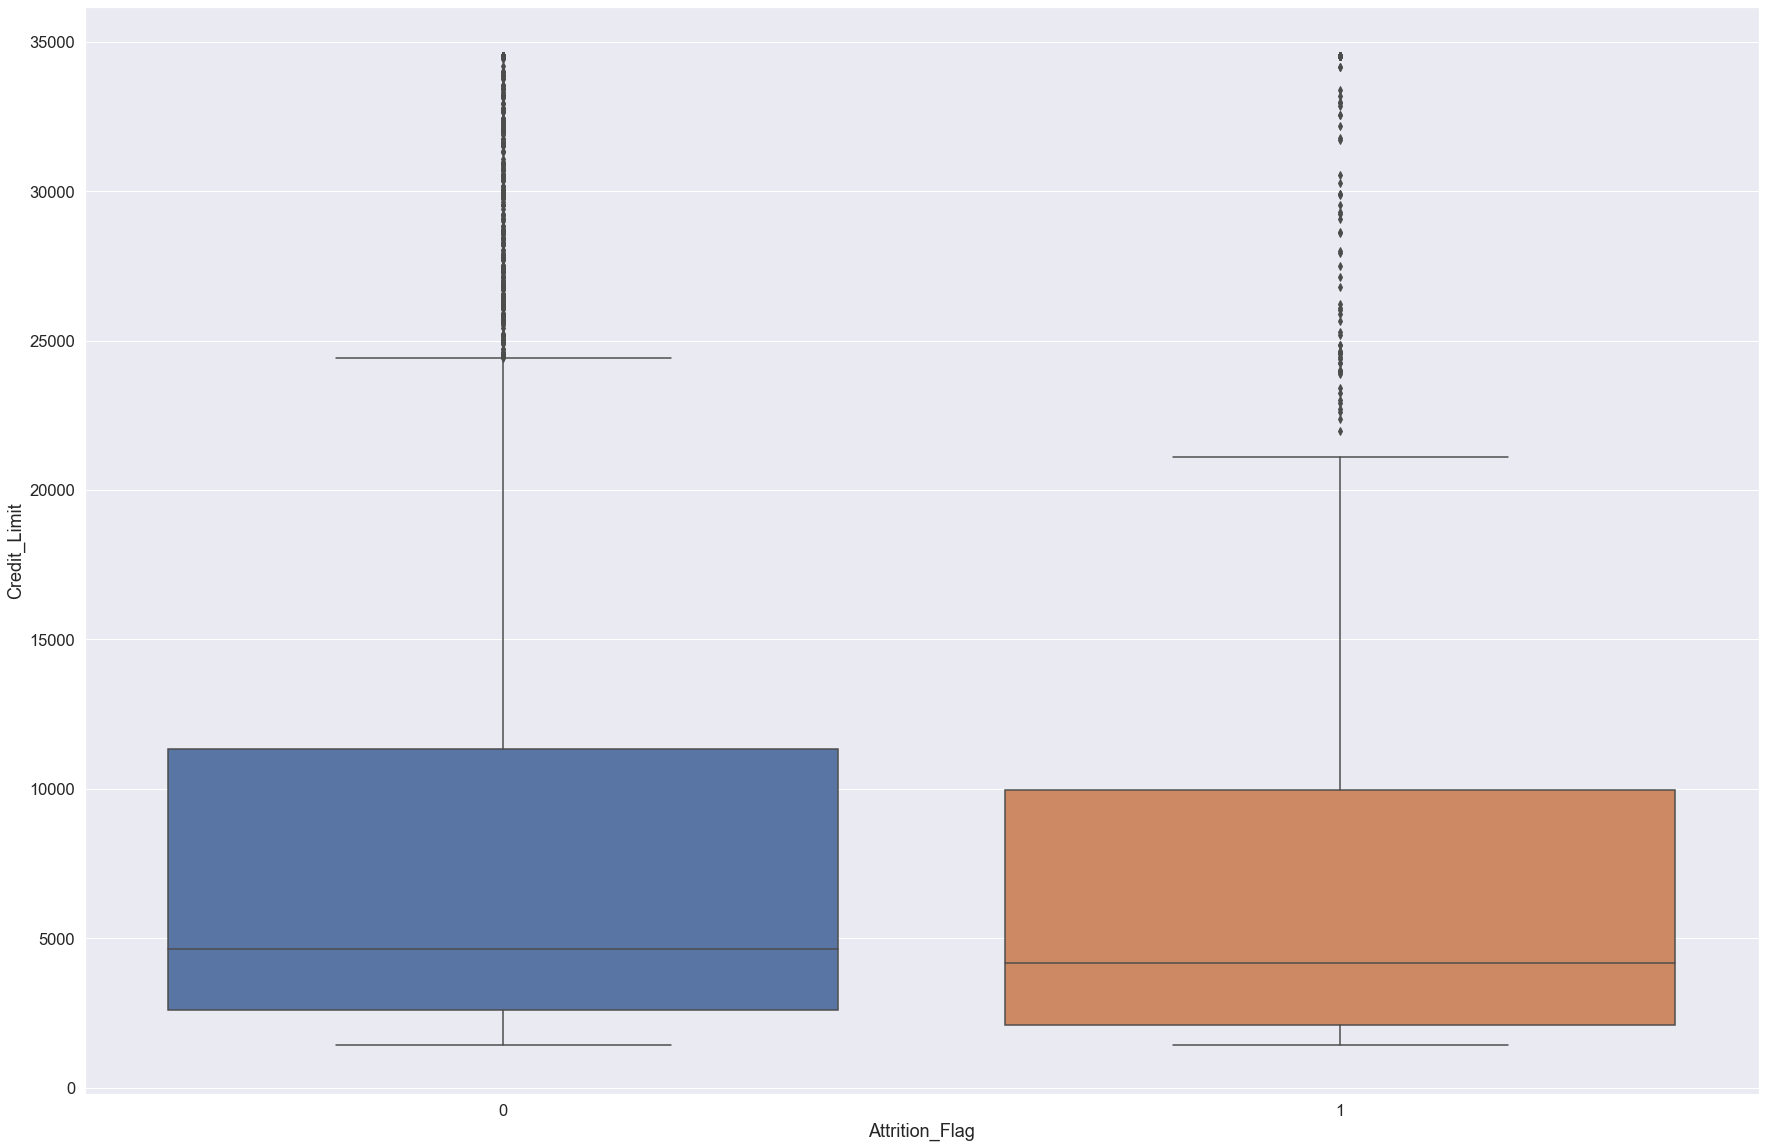

In [27]:
box_plot('Credit_Limit')

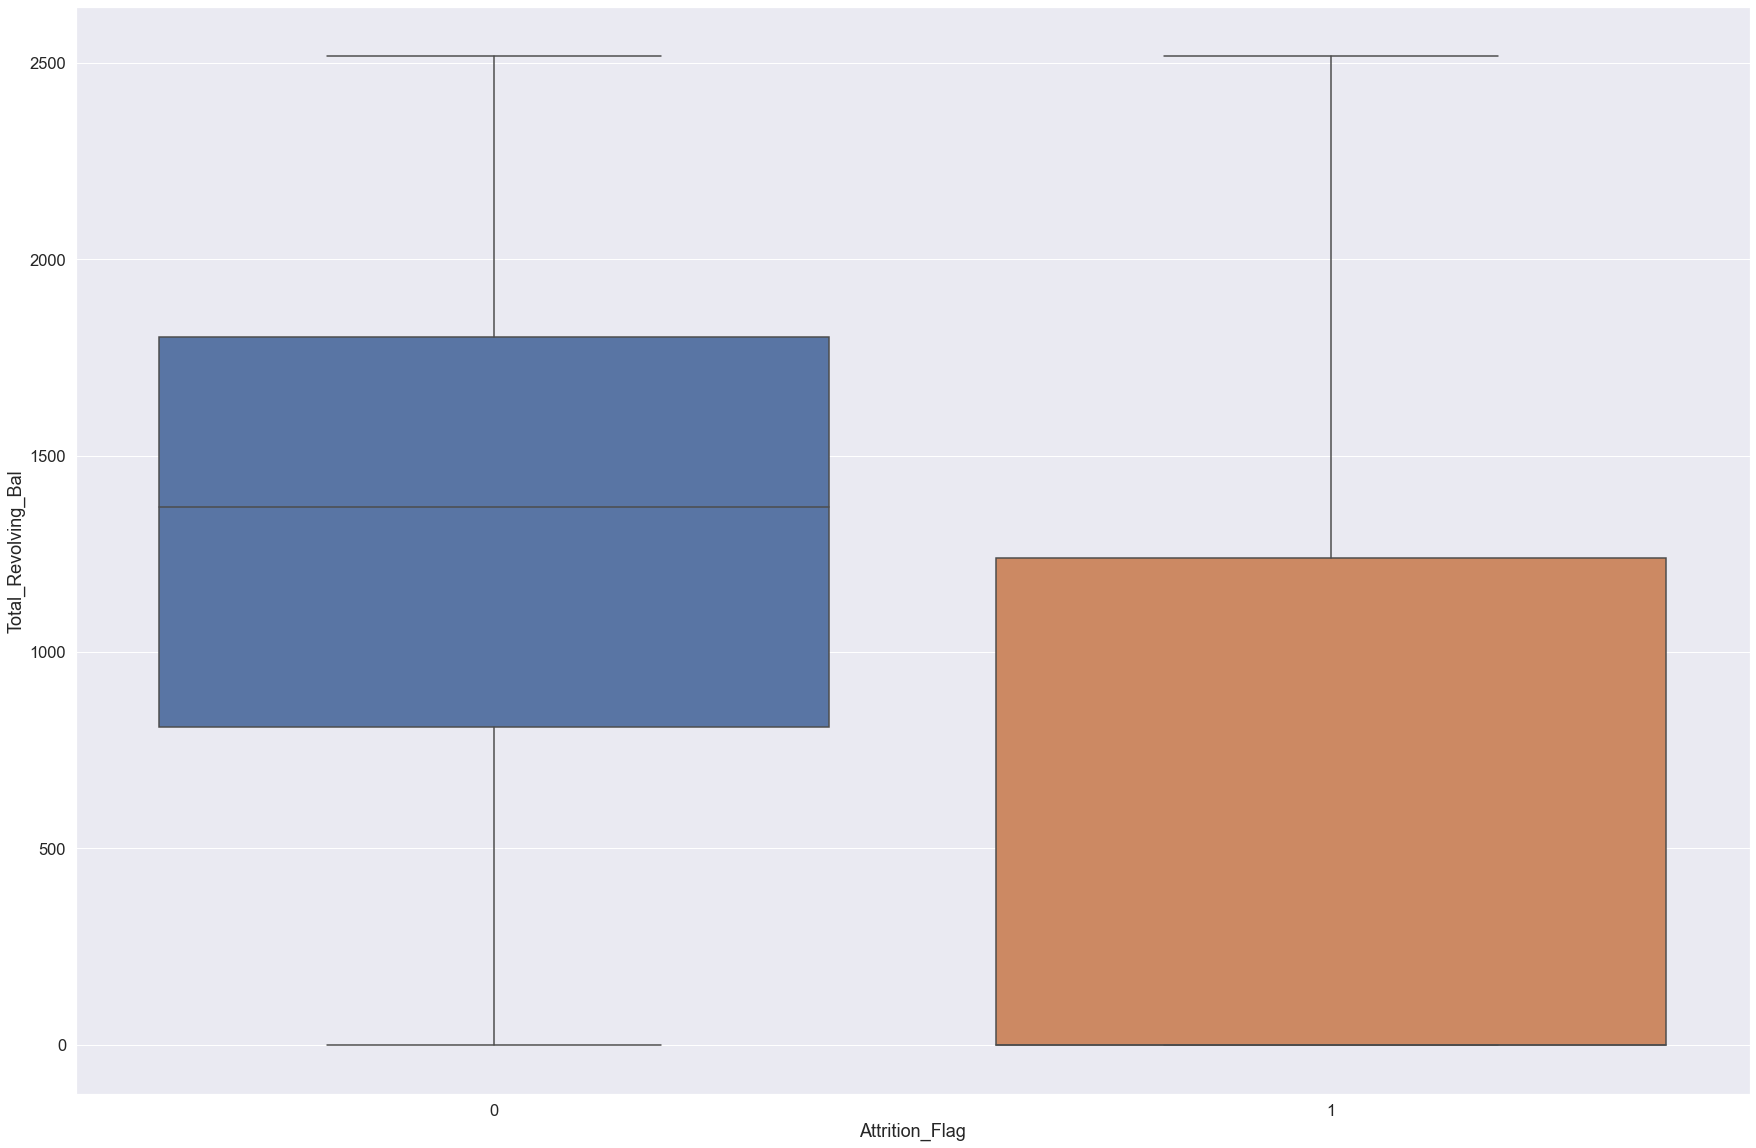

In [28]:
box_plot('Total_Revolving_Bal')

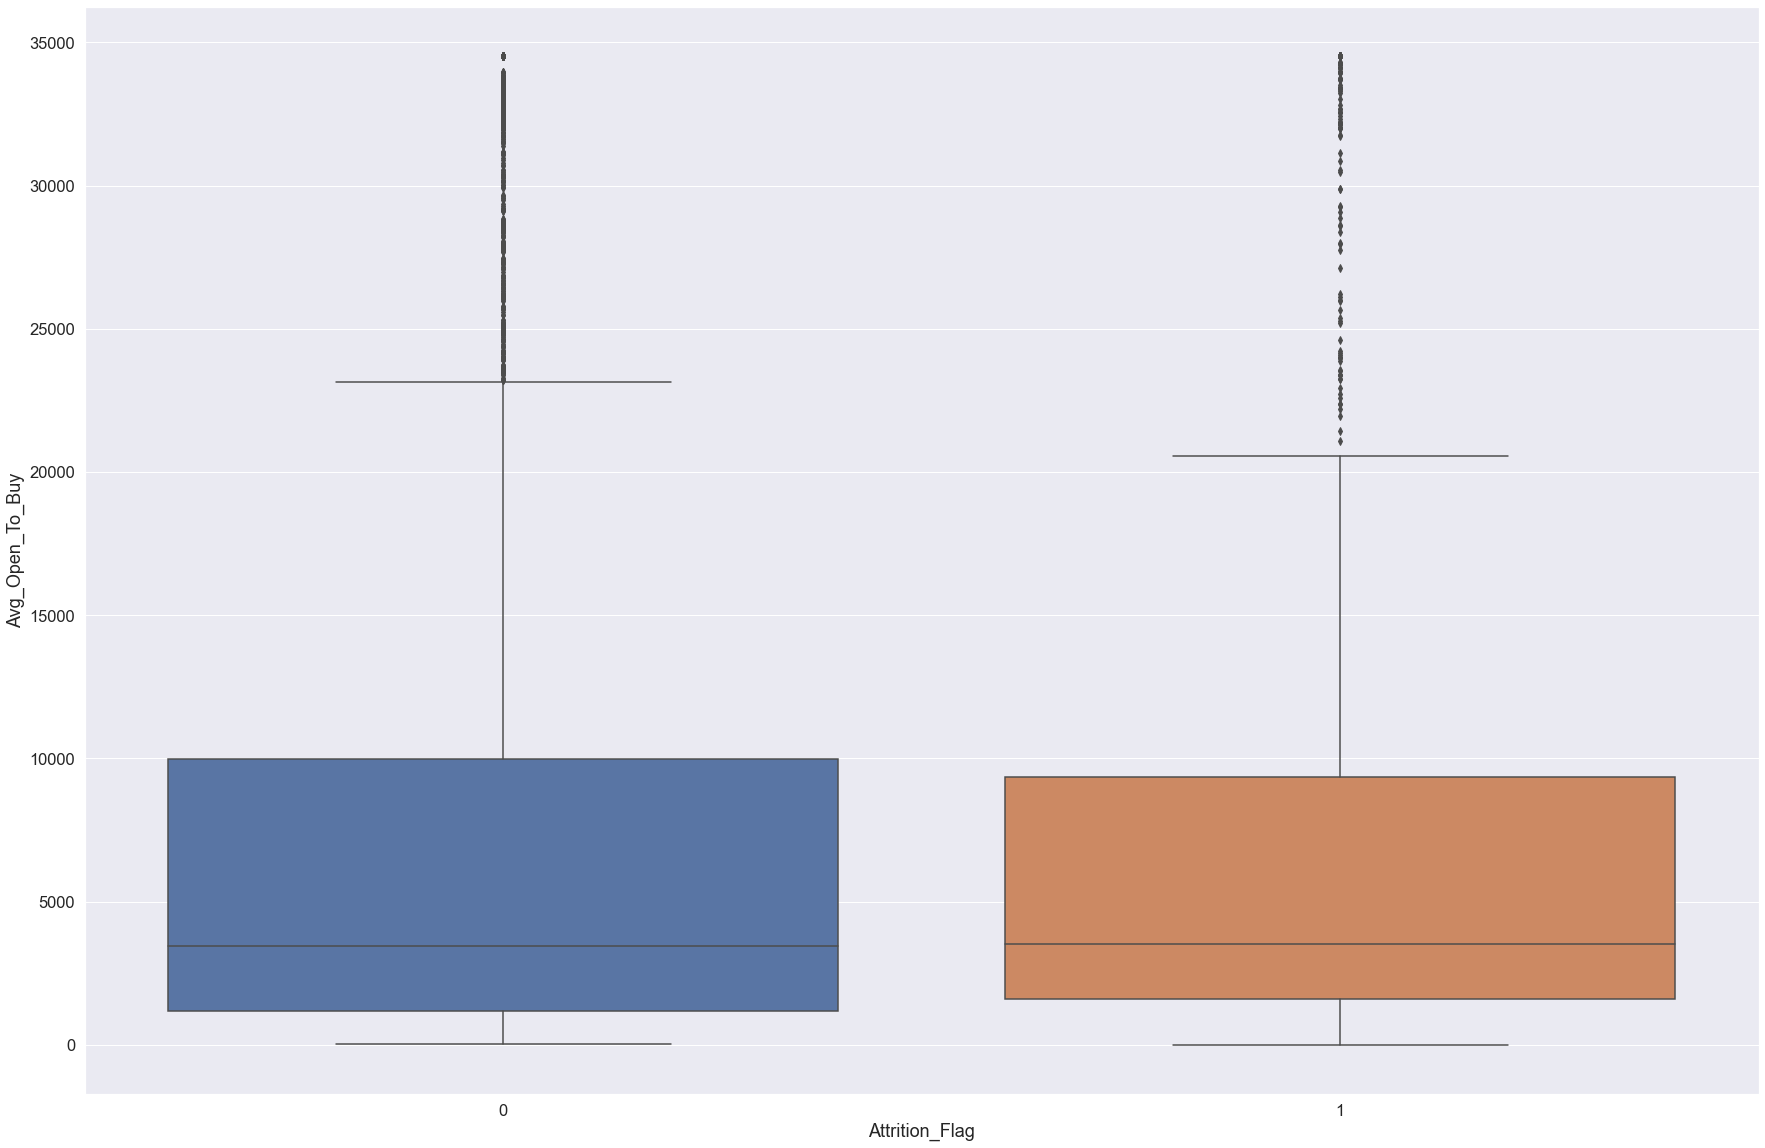

In [29]:
box_plot('Avg_Open_To_Buy')

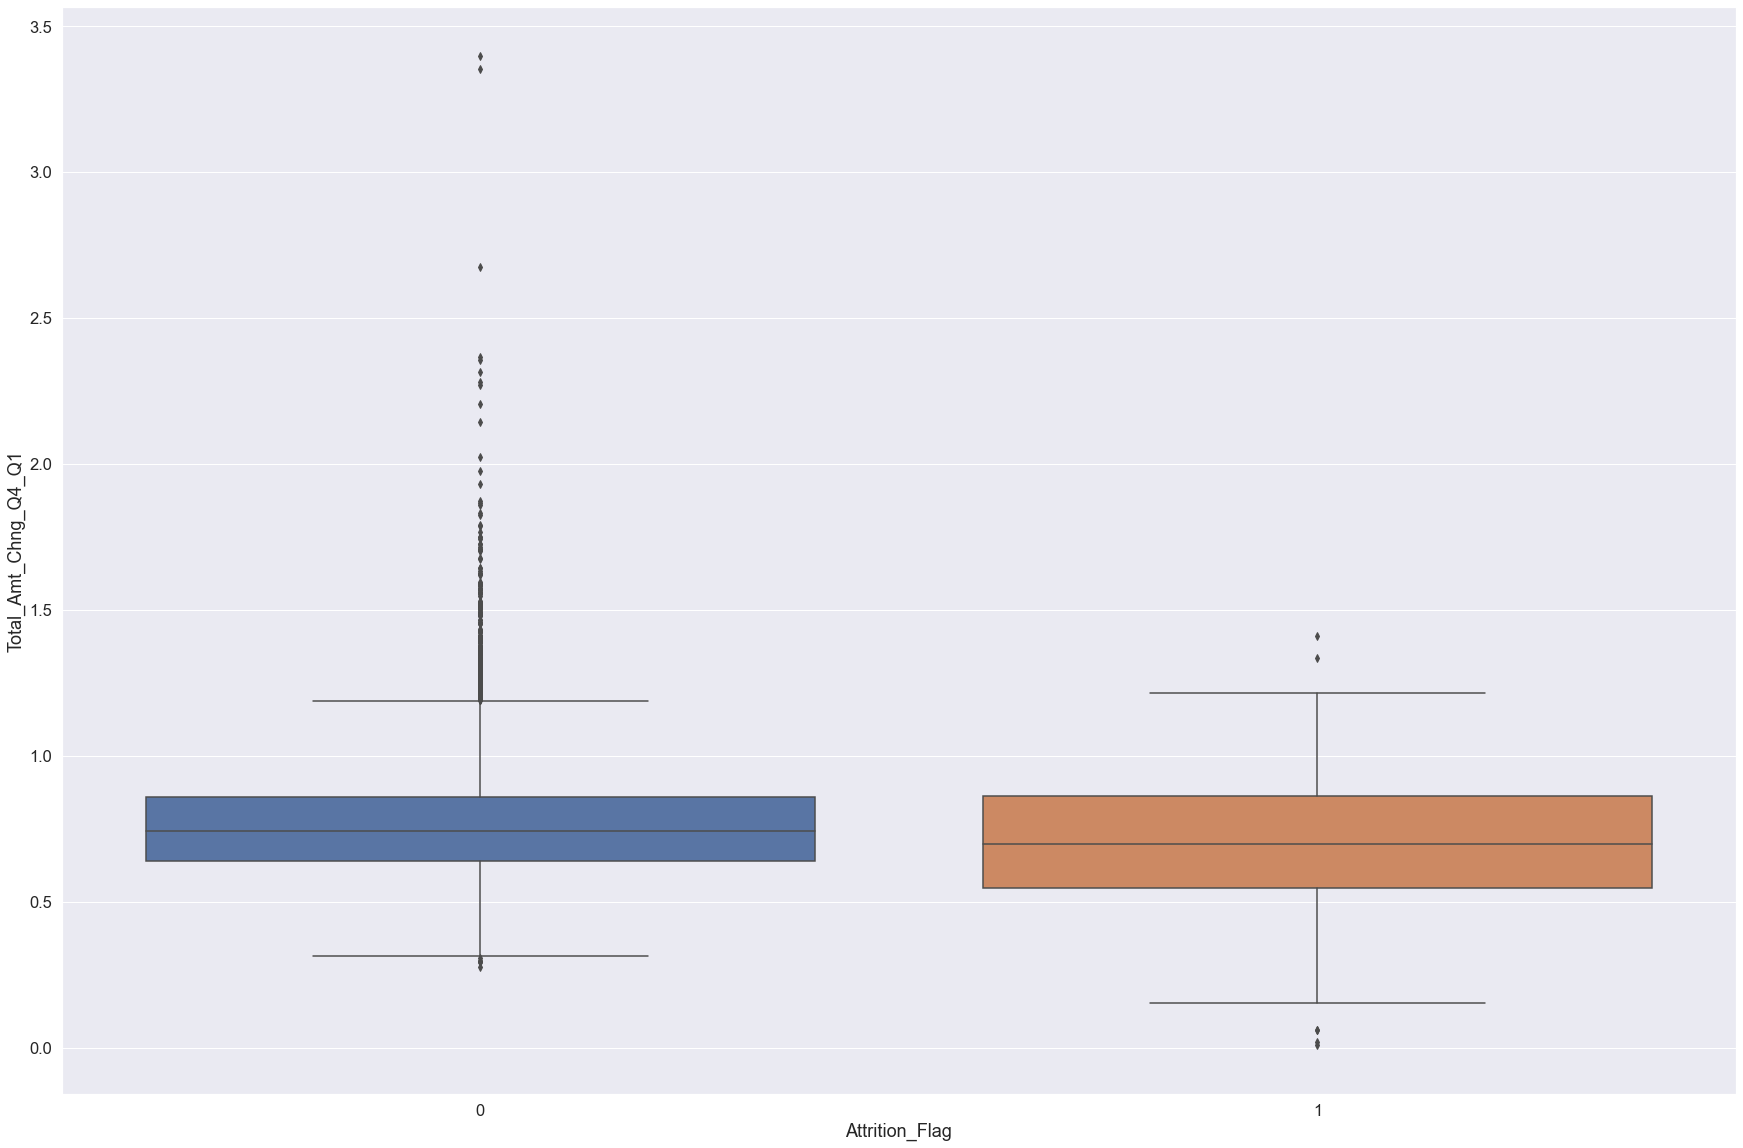

In [30]:
box_plot('Total_Amt_Chng_Q4_Q1')

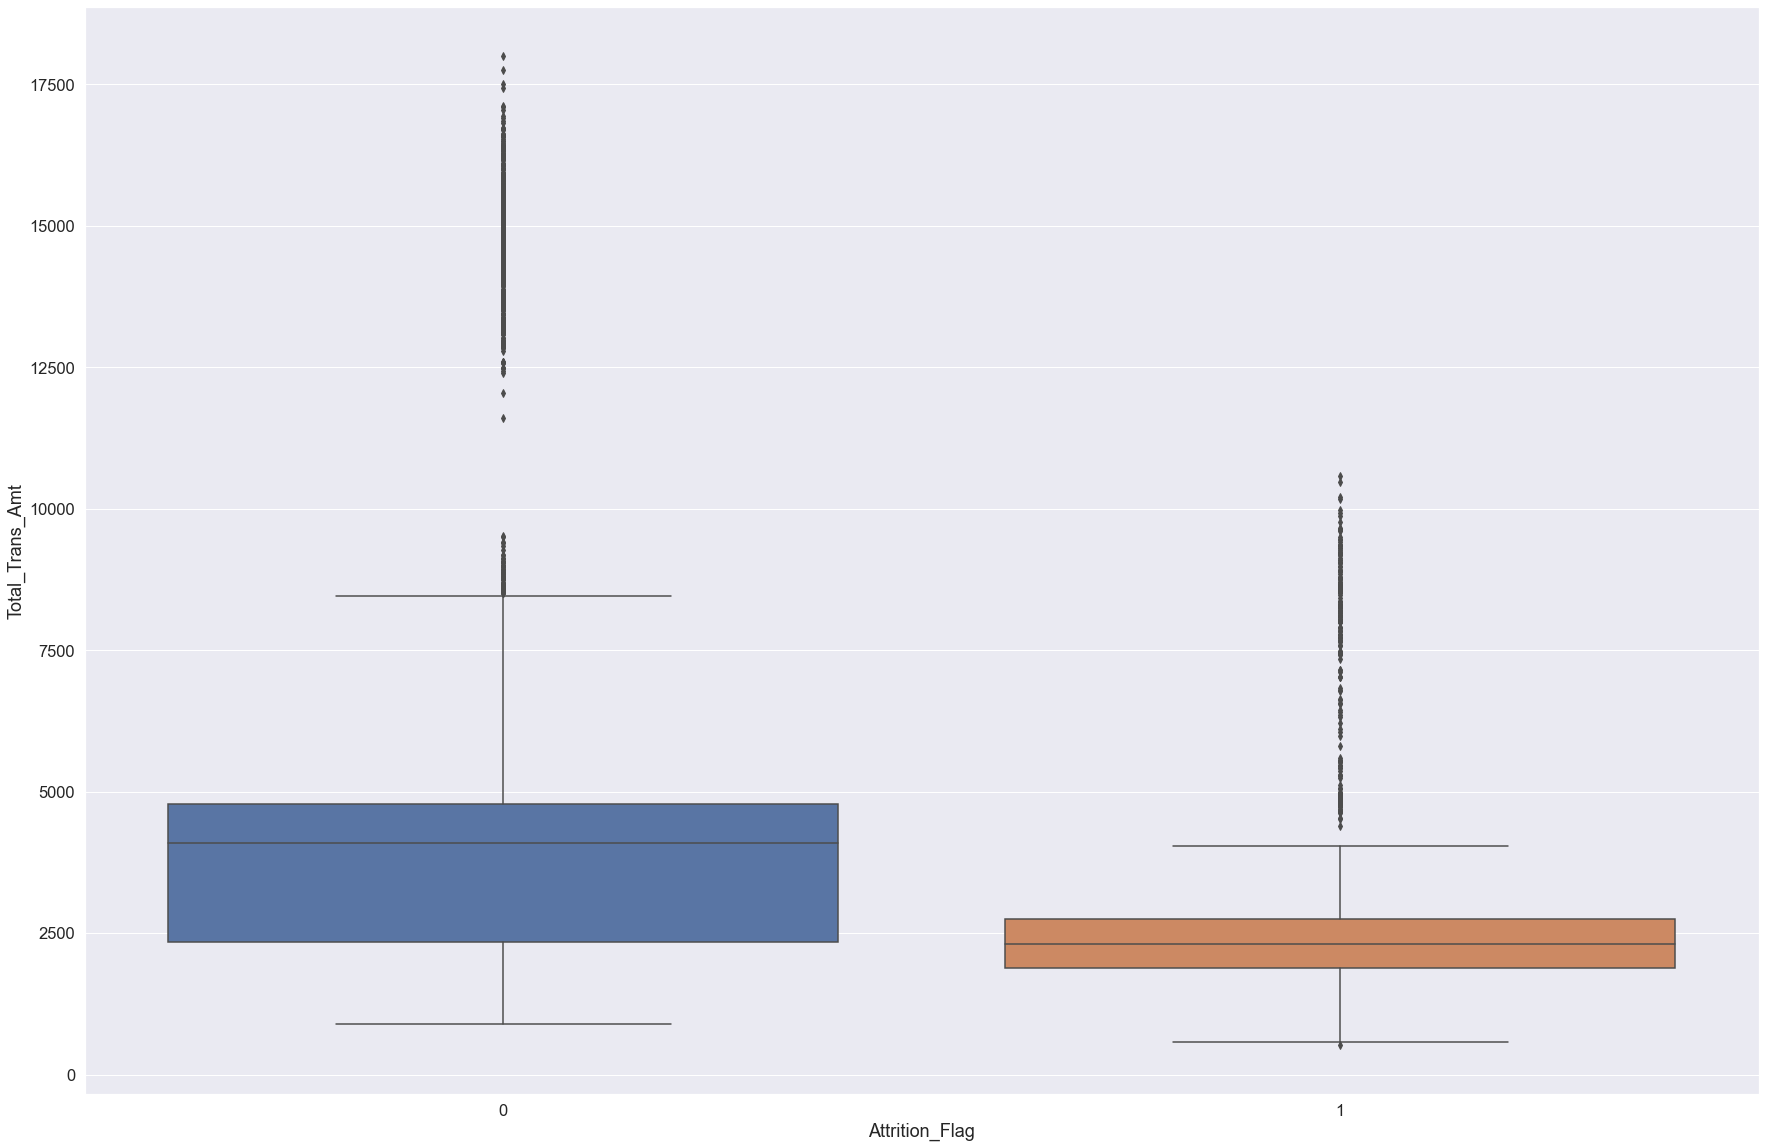

In [31]:
box_plot('Total_Trans_Amt')

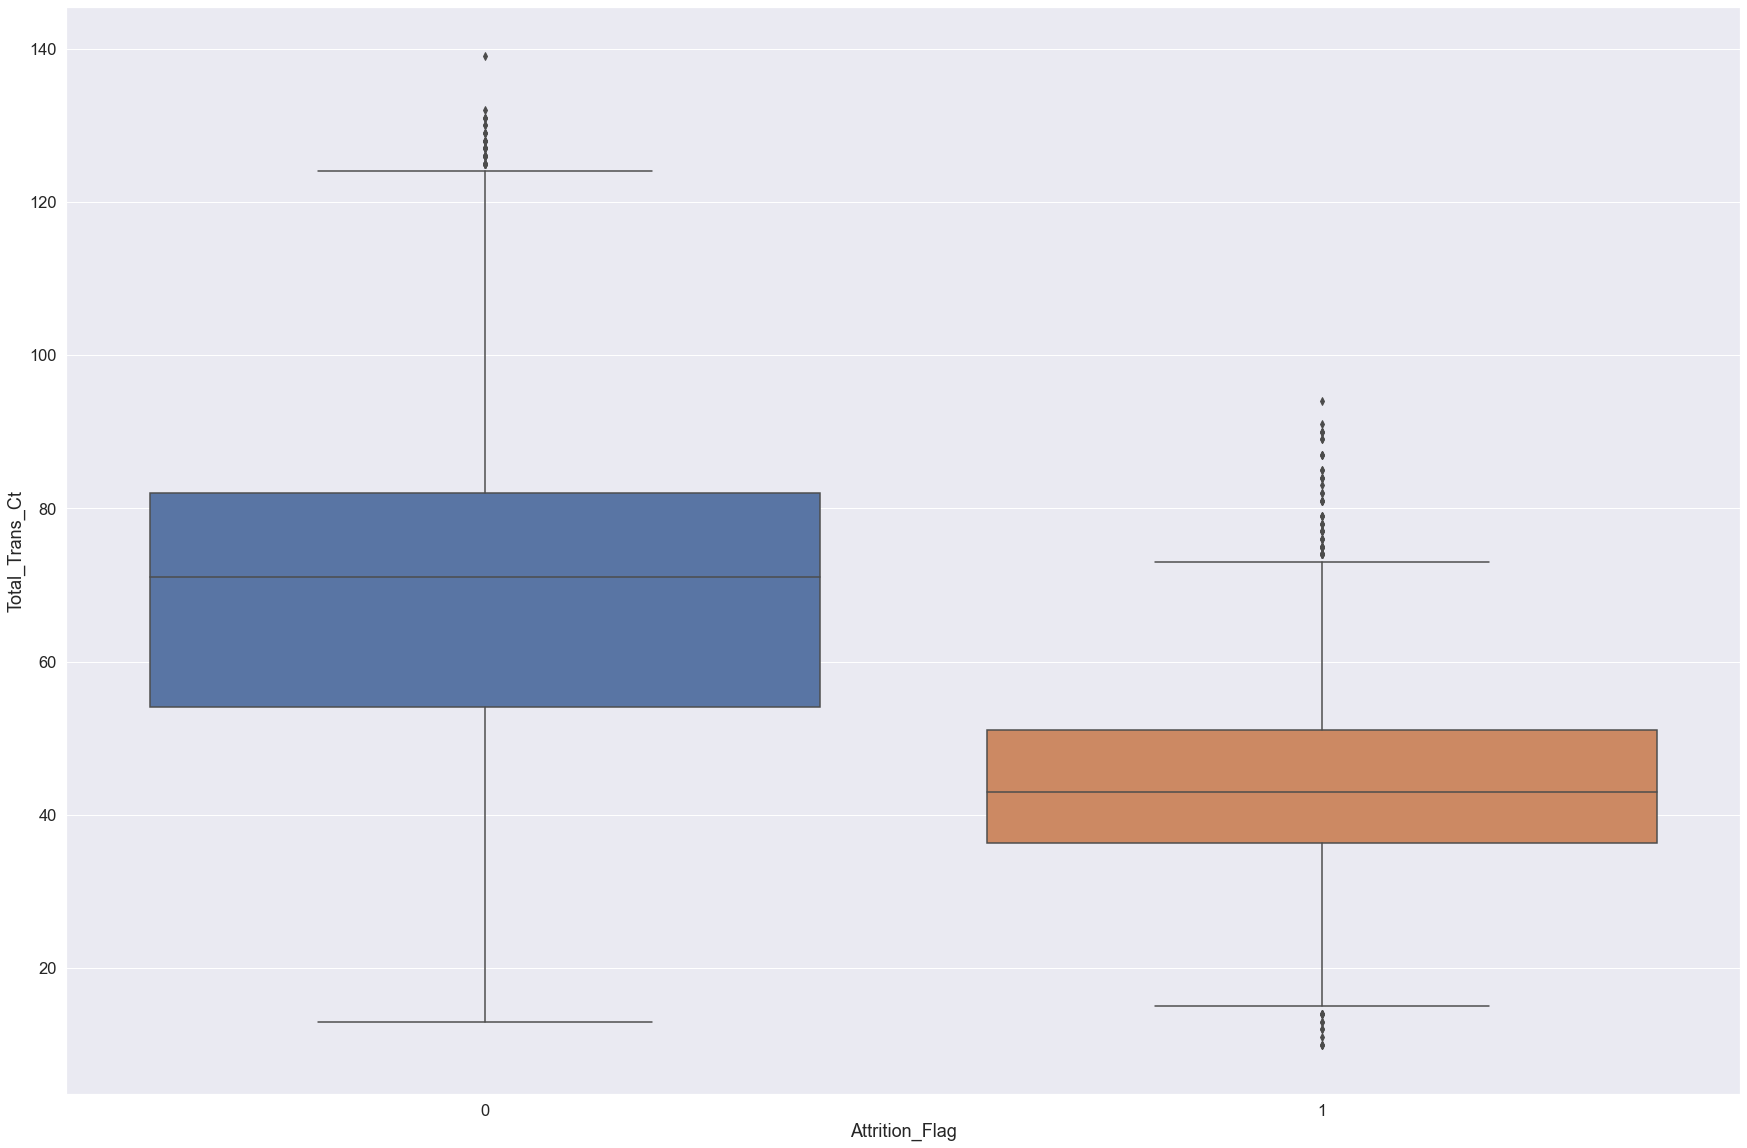

In [32]:
box_plot('Total_Trans_Ct')

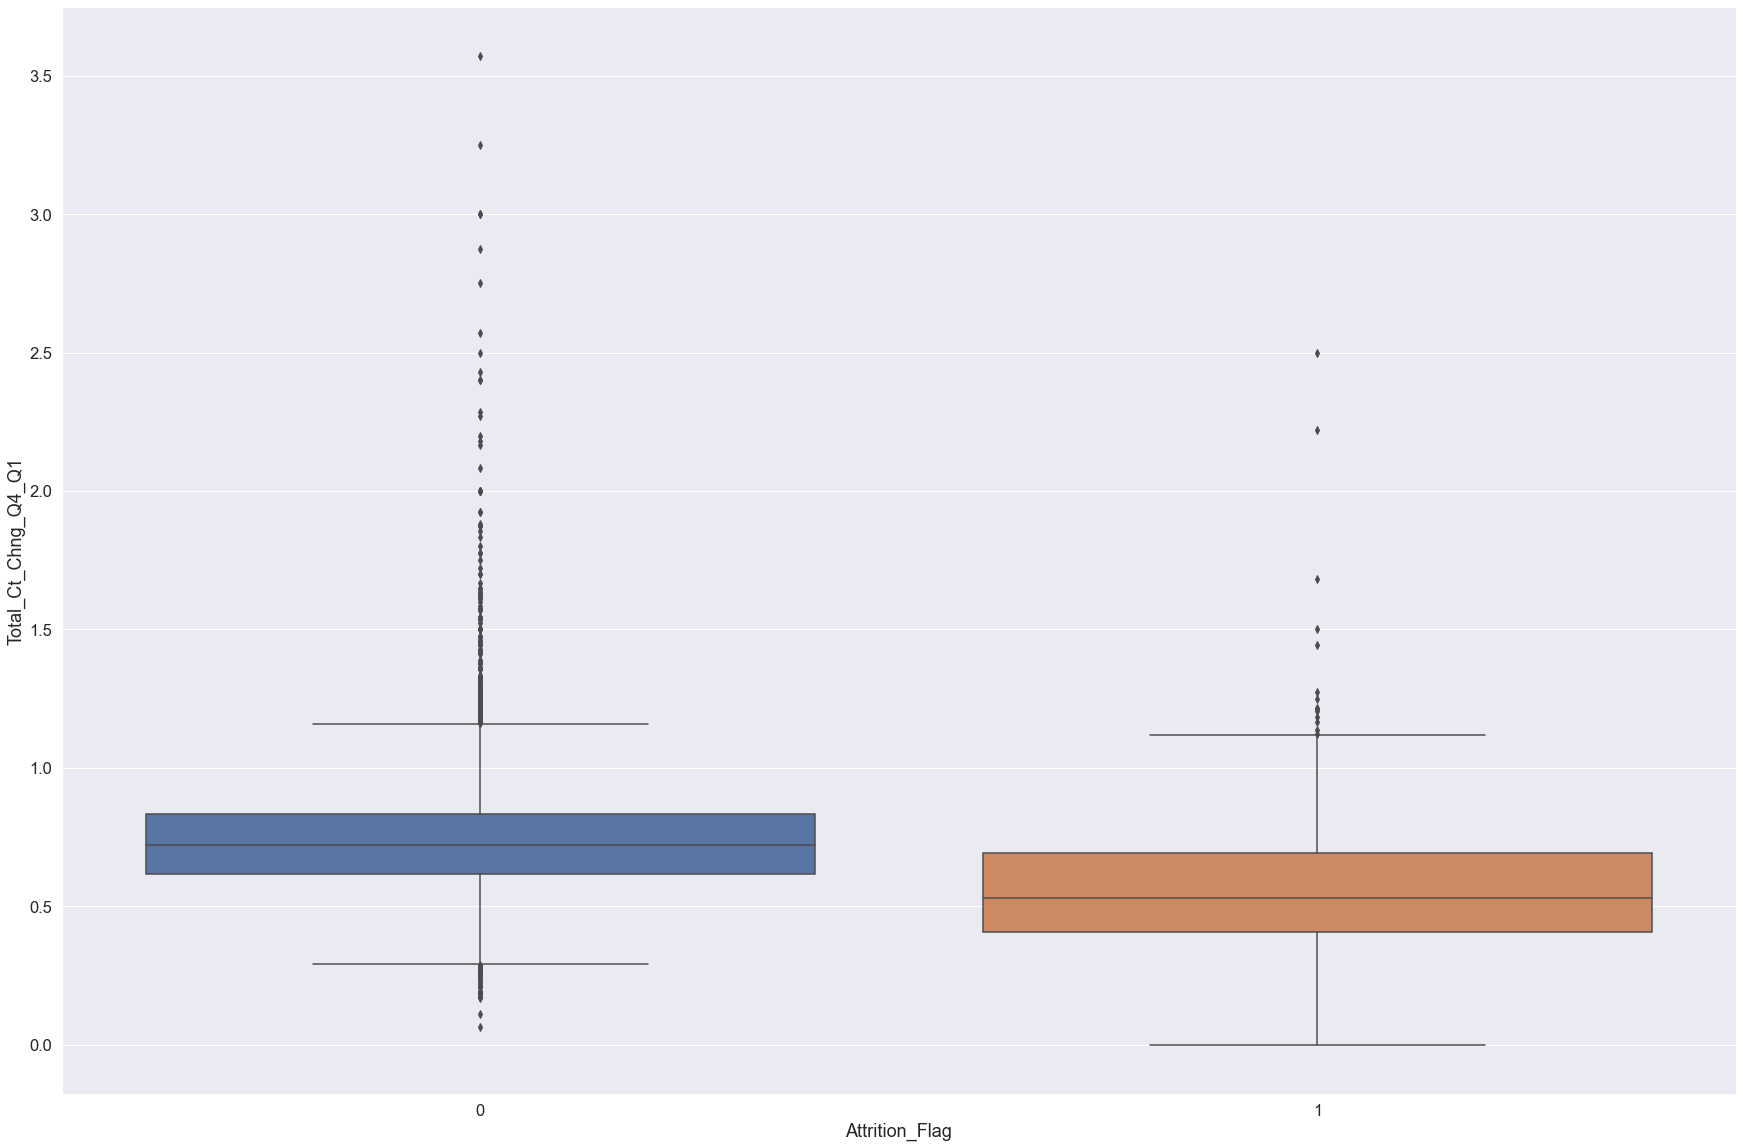

In [33]:
box_plot('Total_Ct_Chng_Q4_Q1')

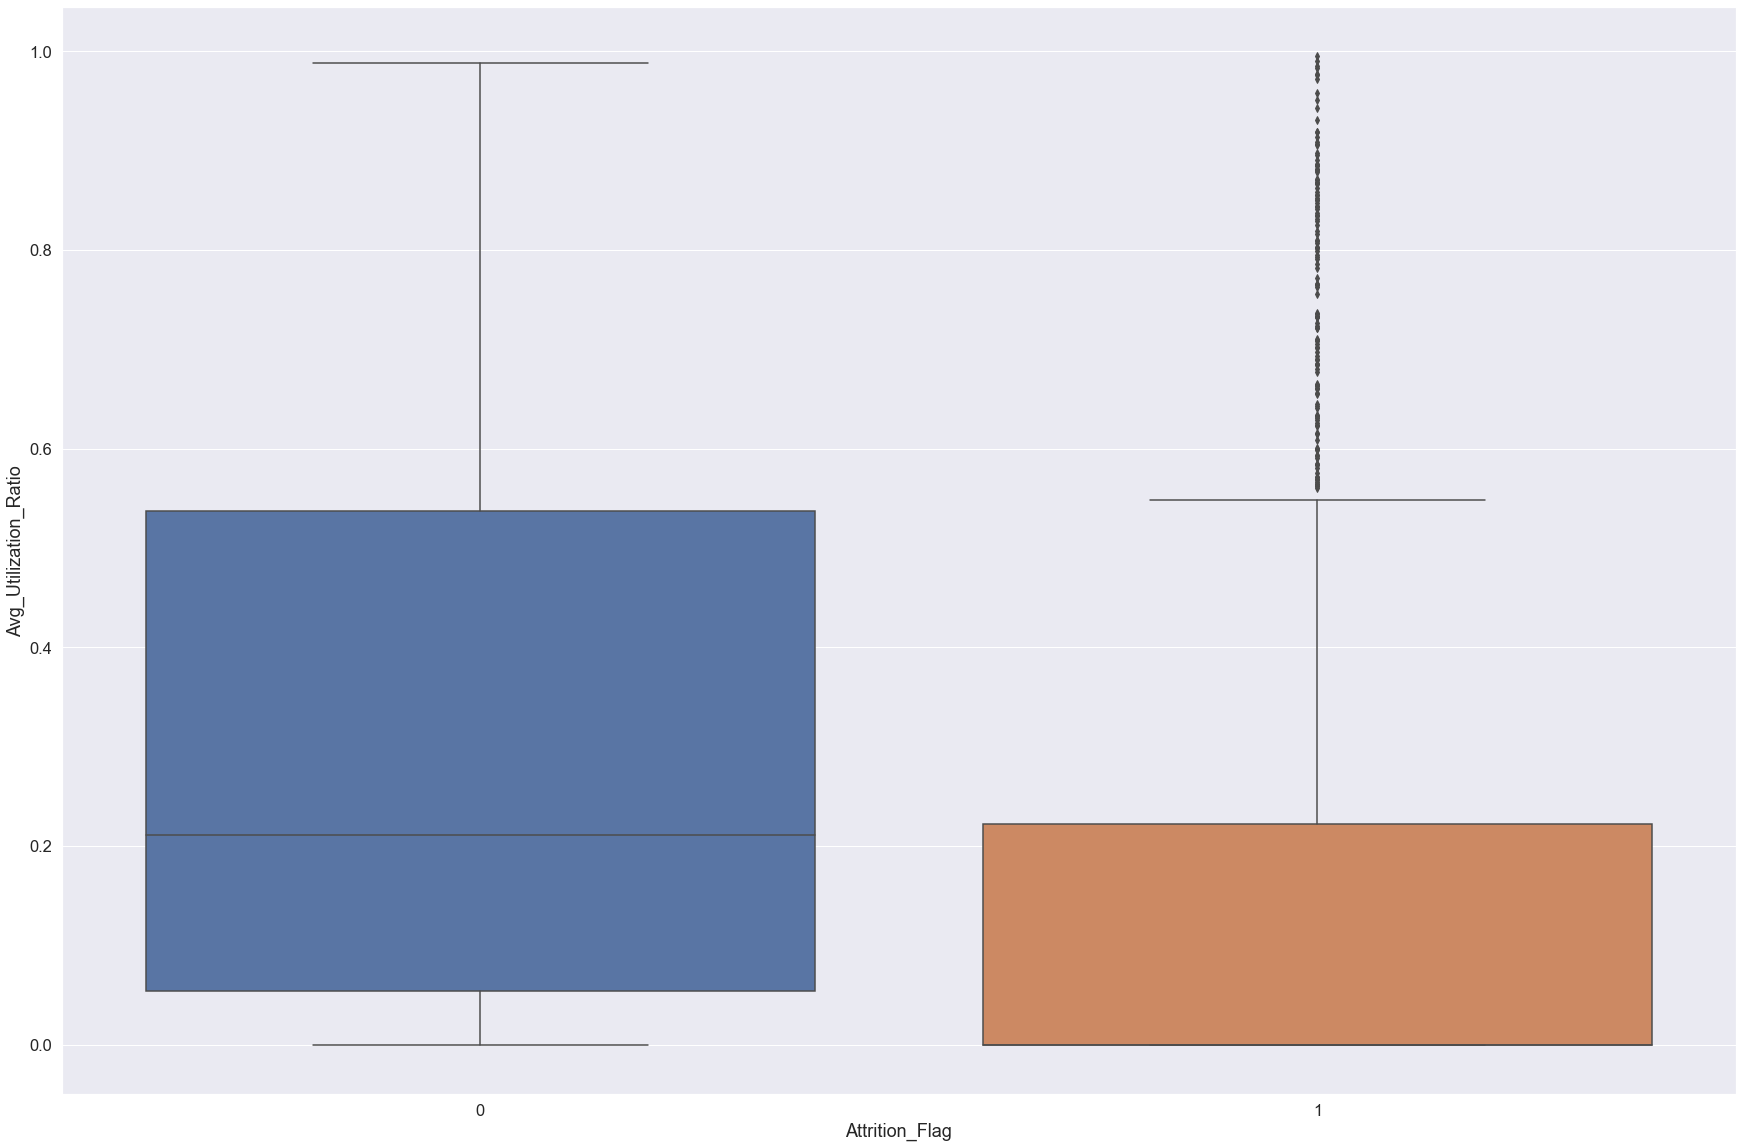

In [34]:
box_plot('Avg_Utilization_Ratio')

## Define a pre-processing pipeline

### Write a custom transform to remove outliers

In [35]:
from sklearn.base import BaseEstimator, TransformerMixin
class RemoveOutliers(BaseEstimator, TransformerMixin):
    
    def __init__(self, feature, min_value, max_value):
        self.feature = feature
        self.min_value = min_value
        self.max_value = max_value
        
    def fit(self, X, y=None):
        return self # nothing else to do
    
    def transform(self, X, y=None):
        
        feature_values = X[self.feature]
        feature_values[feature_values < self.min_value ] = self.min_value
        feature_values[feature_values > self.max_value ] = self.max_value
        
        X[self.feature] = feature_values
        
        return X

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold

numerical_pipeline = Pipeline([
    ('age_outliers',RemoveOutliers('Customer_Age',0,70)),
    ('varianceThreshold', VarianceThreshold()),
    ('std_scaler', StandardScaler())])

full_pipeline = ColumnTransformer([("num", numerical_pipeline, numerical_features)])

X_train_values = full_pipeline.fit_transform(X_train)
X_test_values = full_pipeline.transform(X_test)

In [37]:
X_train[numerical_features] = X_train_values
X_test[numerical_features] = X_test_values

In [38]:
train = pd.concat([X_train, y_train],axis=1)
test = pd.concat([X_test, y_test],axis=1)

# Function to remove columns in both train and test set

In [39]:
def remove_columns(df, columns):
    for c in columns:
        if c in df.columns:
            df.drop(c, axis=1, inplace=True)

## Remove highly correlated columns

In [40]:
from scipy.stats import pearsonr
def highly_correleted_columns(df, columns_to_preserve, threshold):
    corr_columns=[]
    for c in df.columns:
        # column to preserve
        if c in corr_columns:
            continue
        # correlation with pval
        for cc in df.columns:
            if cc == c:
                continue
            if cc in columns_to_preserve:
                continue
            if cc in corr_columns:
                continue
            corrtest = pearsonr(df[c], df[cc])
            corr = corrtest[0]
            pval = corrtest[1]
            if abs(corr) > threshold and pval < 0.05:
                corr_columns.append(cc)
    return corr_columns

In [41]:
columns_to_remove = highly_correleted_columns(train,['Attrition_Flag'], 0.70)
columns_to_remove

['Months_on_book',
 'Gender_M',
 'Avg_Open_To_Buy',
 'Total_Trans_Ct',
 'Marital_Status_Single']

In [42]:
remove_columns(train, columns_to_remove)
remove_columns(test, columns_to_remove)

## Remove highly collinear features

In [43]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
def compute_variance_inflation_factor(df, column_to_predict):

    feature_columns = list(df.columns.values)
    # always remove the column to predict
    feature_columns.remove(column_to_predict)
    features = "+".join(feature_columns)

    # get y and X dataframes based on this regression:
    y, X = dmatrices(column_to_predict + '~' + features, data=df, return_type='dataframe')

    # Calculate VIF Factors, for each X, calculate VIF and save in dataframe
    vif = pd.DataFrame()
    vif["VIF_Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns

    # Inspect VIF Factors
    print(vif.sort_values('VIF_Factor'))
    return vif

In [44]:
vif = compute_variance_inflation_factor(train, 'Attrition_Flag')

    VIF_Factor                       features
5     1.009329         Months_Inactive_12_mon
6     1.028065          Contacts_Count_12_mon
22    1.031166         Card_Category_Platinum
2     1.032599                Dependent_count
1     1.034012                   Customer_Age
20    1.078386         Marital_Status_Unknown
19    1.091843         Marital_Status_Married
21    1.114080             Card_Category_Gold
4     1.148624       Total_Relationship_Count
9     1.177641           Total_Amt_Chng_Q4_Q1
11    1.196279            Total_Ct_Chng_Q4_Q1
10    1.219928                Total_Trans_Amt
23    1.340913           Card_Category_Silver
3     1.372006                Income_Category
13    1.392088      Education_Level_Doctorate
16    1.458103  Education_Level_Post_Graduate
17    2.141278     Education_Level_Uneducated
18    2.169146        Education_Level_Unknown
8     2.232818            Total_Revolving_Bal
15    2.476174    Education_Level_High_School
7     2.643677                   C

In [45]:
nans_columns = vif[vif.isin([np.nan, np.inf, -np.inf]).any(1)].features.values
remove_columns(train, nans_columns)
remove_columns(test, nans_columns)

In [46]:
highly_collinear = vif.loc[vif.VIF_Factor > 5.0].features.values
remove_columns(train, highly_collinear)
remove_columns(test, highly_collinear)

# 3. Modelling

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, recall_score
import optuna

## Plot confusion matrix

In [48]:
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## XGBoost classifier

## Use SMOTE and RandomUnderSampler to reduce imbalance

In [49]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imblearn_pipeline

over = BorderlineSMOTE(sampling_strategy=0.3)
under = RandomUnderSampler(sampling_strategy=0.6)
steps = [('oversampling', over), ('undersampling', under)]

def objectiveXGBoost(trial):
    
    over = BorderlineSMOTE(sampling_strategy=0.3)
    under = RandomUnderSampler(sampling_strategy=0.6)
    
    gamma_int = trial.suggest_float('gamma', 0.01, 10,log=True)
    max_depth = trial.suggest_int('max_depth', 1, 5)
    clf = xgb.XGBClassifier(n_jobs=3,seed=42,gamma=gamma_int,max_depth=max_depth)
    
    # by using a pipeline the metric is computed on the original, not balanced dataset
    full_pipeline = imblearn_pipeline( [('oversampling', over), ('undersampling', under),('model',clf)])
    
    # stratified k-fold cross-validation 
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    
    return cross_val_score(full_pipeline, X_train,y_train, n_jobs = 3, cv=cv, scoring='neg_log_loss').mean()

In [50]:
import optuna
study = optuna.create_study(direction='maximize')
study.optimize(objectiveXGBoost, n_trials=300)
trial = study.best_trial
print(trial.params)

[I 2021-03-08 11:11:14,677] A new study created in memory with name: no-name-88348937-d103-4b8b-975f-a4da783fd730
[I 2021-03-08 11:11:21,524] Trial 0 finished with value: -0.09849911961379647 and parameters: {'gamma': 0.01981263564878679, 'max_depth': 2}. Best is trial 0 with value: -0.09849911961379647.
[I 2021-03-08 11:11:27,329] Trial 1 finished with value: -0.10174400235105814 and parameters: {'gamma': 3.5552444893185977, 'max_depth': 3}. Best is trial 0 with value: -0.09849911961379647.
[I 2021-03-08 11:11:33,599] Trial 2 finished with value: -0.08434161867821259 and parameters: {'gamma': 0.4470591785481731, 'max_depth': 4}. Best is trial 2 with value: -0.08434161867821259.
[I 2021-03-08 11:11:40,332] Trial 3 finished with value: -0.0902454936650992 and parameters: {'gamma': 0.1634333877840929, 'max_depth': 5}. Best is trial 2 with value: -0.08434161867821259.
[I 2021-03-08 11:11:46,271] Trial 4 finished with value: -0.08494731633144031 and parameters: {'gamma': 0.0119533933552979

[I 2021-03-08 11:16:00,107] Trial 41 finished with value: -0.09909362987526468 and parameters: {'gamma': 0.10490349633717688, 'max_depth': 2}. Best is trial 21 with value: -0.0828656717363775.
[I 2021-03-08 11:16:04,975] Trial 42 finished with value: -0.1796744549473385 and parameters: {'gamma': 0.365471049259968, 'max_depth': 1}. Best is trial 21 with value: -0.0828656717363775.
[I 2021-03-08 11:16:11,035] Trial 43 finished with value: -0.08479009860562271 and parameters: {'gamma': 0.10395243701971879, 'max_depth': 3}. Best is trial 21 with value: -0.0828656717363775.
[I 2021-03-08 11:16:17,713] Trial 44 finished with value: -0.08454211734213431 and parameters: {'gamma': 0.1980068227814976, 'max_depth': 4}. Best is trial 21 with value: -0.0828656717363775.
[I 2021-03-08 11:16:23,878] Trial 45 finished with value: -0.08473207192963393 and parameters: {'gamma': 0.027832477569079382, 'max_depth': 3}. Best is trial 21 with value: -0.0828656717363775.
[I 2021-03-08 11:16:30,591] Trial 46 f

[I 2021-03-08 11:21:44,077] Trial 83 finished with value: -0.0869992988122942 and parameters: {'gamma': 1.0440799776250327, 'max_depth': 4}. Best is trial 21 with value: -0.0828656717363775.
[I 2021-03-08 11:21:51,833] Trial 84 finished with value: -0.08372508384469286 and parameters: {'gamma': 0.49288672529288924, 'max_depth': 4}. Best is trial 21 with value: -0.0828656717363775.
[I 2021-03-08 11:21:59,106] Trial 85 finished with value: -0.0844591466977364 and parameters: {'gamma': 0.31189973512527447, 'max_depth': 4}. Best is trial 21 with value: -0.0828656717363775.
[I 2021-03-08 11:22:06,137] Trial 86 finished with value: -0.08542908754818207 and parameters: {'gamma': 0.7223807276231596, 'max_depth': 4}. Best is trial 21 with value: -0.0828656717363775.
[I 2021-03-08 11:22:12,928] Trial 87 finished with value: -0.08486207308531671 and parameters: {'gamma': 0.5886838458351432, 'max_depth': 4}. Best is trial 21 with value: -0.0828656717363775.
[I 2021-03-08 11:22:20,206] Trial 88 fin

[I 2021-03-08 11:26:35,982] Trial 125 finished with value: -0.0855911055528443 and parameters: {'gamma': 0.05319842590021928, 'max_depth': 4}. Best is trial 110 with value: -0.08265952230449566.
[I 2021-03-08 11:26:42,712] Trial 126 finished with value: -0.0857367509038776 and parameters: {'gamma': 0.23803841969188275, 'max_depth': 4}. Best is trial 110 with value: -0.08265952230449566.
[I 2021-03-08 11:26:49,702] Trial 127 finished with value: -0.08525140250227999 and parameters: {'gamma': 0.11774945059020557, 'max_depth': 4}. Best is trial 110 with value: -0.08265952230449566.
[I 2021-03-08 11:26:56,326] Trial 128 finished with value: -0.08370078081792931 and parameters: {'gamma': 0.15092560899206192, 'max_depth': 4}. Best is trial 110 with value: -0.08265952230449566.
[I 2021-03-08 11:27:03,011] Trial 129 finished with value: -0.08475734340808366 and parameters: {'gamma': 0.3315019066348809, 'max_depth': 4}. Best is trial 110 with value: -0.08265952230449566.
[I 2021-03-08 11:27:09,

[I 2021-03-08 11:31:16,618] Trial 166 finished with value: -0.08698802510021178 and parameters: {'gamma': 0.6548445922562689, 'max_depth': 4}. Best is trial 135 with value: -0.08237153901838257.
[I 2021-03-08 11:31:23,276] Trial 167 finished with value: -0.08543625870556867 and parameters: {'gamma': 0.1369403754667198, 'max_depth': 4}. Best is trial 135 with value: -0.08237153901838257.
[I 2021-03-08 11:31:30,119] Trial 168 finished with value: -0.0851663413564827 and parameters: {'gamma': 0.08268000449618307, 'max_depth': 4}. Best is trial 135 with value: -0.08237153901838257.
[I 2021-03-08 11:31:37,092] Trial 169 finished with value: -0.08471969948595381 and parameters: {'gamma': 0.48809128116542666, 'max_depth': 4}. Best is trial 135 with value: -0.08237153901838257.
[I 2021-03-08 11:31:43,915] Trial 170 finished with value: -0.08491096433305297 and parameters: {'gamma': 0.3417276867616905, 'max_depth': 4}. Best is trial 135 with value: -0.08237153901838257.
[I 2021-03-08 11:31:50,8

[I 2021-03-08 11:36:01,961] Trial 207 finished with value: -0.08531755233783953 and parameters: {'gamma': 0.49913265907467685, 'max_depth': 4}. Best is trial 135 with value: -0.08237153901838257.
[I 2021-03-08 11:36:09,043] Trial 208 finished with value: -0.08738776036678918 and parameters: {'gamma': 1.0076331274167907, 'max_depth': 4}. Best is trial 135 with value: -0.08237153901838257.
[I 2021-03-08 11:36:15,956] Trial 209 finished with value: -0.0848685003024247 and parameters: {'gamma': 0.7747874584816635, 'max_depth': 4}. Best is trial 135 with value: -0.08237153901838257.
[I 2021-03-08 11:36:22,481] Trial 210 finished with value: -0.08471431014669337 and parameters: {'gamma': 0.24957960606020899, 'max_depth': 4}. Best is trial 135 with value: -0.08237153901838257.
[I 2021-03-08 11:36:29,011] Trial 211 finished with value: -0.08509843488114652 and parameters: {'gamma': 0.4525140901641749, 'max_depth': 4}. Best is trial 135 with value: -0.08237153901838257.
[I 2021-03-08 11:36:35,6

[I 2021-03-08 11:40:44,596] Trial 248 finished with value: -0.08458420309572524 and parameters: {'gamma': 0.42305662662431115, 'max_depth': 4}. Best is trial 135 with value: -0.08237153901838257.
[I 2021-03-08 11:40:51,737] Trial 249 finished with value: -0.0828530008139889 and parameters: {'gamma': 0.39118791937956615, 'max_depth': 4}. Best is trial 135 with value: -0.08237153901838257.
[I 2021-03-08 11:40:58,508] Trial 250 finished with value: -0.08389416676256492 and parameters: {'gamma': 0.08535642745347843, 'max_depth': 4}. Best is trial 135 with value: -0.08237153901838257.
[I 2021-03-08 11:41:05,203] Trial 251 finished with value: -0.08522272410867321 and parameters: {'gamma': 0.39756458980812664, 'max_depth': 4}. Best is trial 135 with value: -0.08237153901838257.
[I 2021-03-08 11:41:12,083] Trial 252 finished with value: -0.08459076472448368 and parameters: {'gamma': 0.14895588740338025, 'max_depth': 4}. Best is trial 135 with value: -0.08237153901838257.
[I 2021-03-08 11:41:1

[I 2021-03-08 11:45:36,340] Trial 289 finished with value: -0.08389971683690087 and parameters: {'gamma': 0.05280179307109893, 'max_depth': 4}. Best is trial 135 with value: -0.08237153901838257.
[I 2021-03-08 11:45:45,554] Trial 290 finished with value: -0.08621284028926879 and parameters: {'gamma': 0.6919616492665676, 'max_depth': 4}. Best is trial 135 with value: -0.08237153901838257.
[I 2021-03-08 11:45:54,997] Trial 291 finished with value: -0.08385001018985334 and parameters: {'gamma': 0.4539045199318527, 'max_depth': 4}. Best is trial 135 with value: -0.08237153901838257.
[I 2021-03-08 11:46:03,413] Trial 292 finished with value: -0.08542993454723462 and parameters: {'gamma': 0.048222566642178534, 'max_depth': 4}. Best is trial 135 with value: -0.08237153901838257.
[I 2021-03-08 11:46:11,684] Trial 293 finished with value: -0.08623855508150649 and parameters: {'gamma': 0.5645652274238236, 'max_depth': 4}. Best is trial 135 with value: -0.08237153901838257.
[I 2021-03-08 11:46:19

{'gamma': 0.28458236142644344, 'max_depth': 4}


## The dataset used for fitting should be re-balanced

In [51]:
over = BorderlineSMOTE(sampling_strategy=0.3)
under = RandomUnderSampler(sampling_strategy=0.6)
steps = [('oversampling', over), ('undersampling', under)]
sampling_pipeline = imblearn_pipeline(steps=steps)
X_train_fit, y_train_fit = sampling_pipeline.fit_resample(X_train, y_train)

In [52]:
clf = xgb.XGBClassifier()
clf.set_params(**study.best_trial.params)
clf.fit(X_train_fit,y_train_fit)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.28458236142644344,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [53]:
yhat = clf.predict(X_test)

Normalized confusion matrix
[[0.98003565 0.01996435]
 [0.08193669 0.91806331]]
Recall is  0.9490494826676226


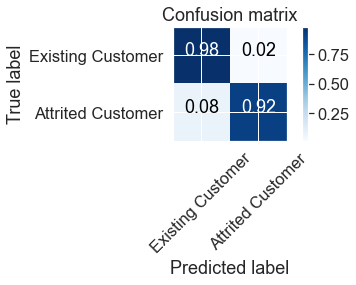

In [54]:
cnf_matrix = confusion_matrix(y_test, yhat, labels=[0,1])
plot_confusion_matrix(cnf_matrix, classes=['Existing Customer','Attrited Customer'],normalize=True,  title='Confusion matrix')
print('Recall is ', recall_score(y_test, yhat, average='macro'))